In [1]:
import cv2
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
import tensorflow as tf
from tensorflow import keras

import sys
from pathlib import Path
scripts_dir = Path().resolve()

function_dir = scripts_dir.parent
sys.path.insert(0, str(function_dir))
import Functions.mouse as mouse
import SSM.ssm as ssm
from SSM.ssm.plots import gradient_cmap

parent_dir = scripts_dir.parent.parent/'aeon_mecha'
sys.path.insert(0, str(parent_dir))
import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.schemas import social02

LABELS = [
    ['AEON3', 'Pre','BAA-1104045'],
    ['AEON3', 'Pre','BAA-1104047'],
    ['AEON3', 'Post','BAA-1104045'],
    ['AEON3', 'Post','BAA-1104047'],
    ['AEON4', 'Pre','BAA-1104048'], 
    ['AEON4', 'Pre','BAA-1104049'],
    ['AEON4', 'Post','BAA-1104048'],
    ['AEON4', 'Post','BAA-1104049']
]
nodes_name = ['nose', 'head', 'right_ear', 'left_ear', 'spine1', 'spine2','spine3', 'spine4']
color_names = [
    'black', 'blue', 'red', 'tan', 'green', 'brown', 
    'purple', 'orange', 'turquoise', 'yellow', 'pink', 
    'darkblue', 'lime', 'cyan', 'magenta', 'gold', 
    'navy', 'maroon', 'teal', 'grey'
]

2024-06-24 10:47:04.904176: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/cv2/../../lib64:
2024-06-24 10:47:04.904267: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# **0. Get Data for the Single-Mouse Experiment**

In [2]:
Mouse = mouse.Mouse(aeon_exp = 'AEON3', type = 'Pre', mouse = 'BAA-1104047')

## ***I. Information***

In [13]:
print(Mouse.aeon_exp, Mouse.type, Mouse.mouse)
print(Mouse.root)

AEON3 Pre BAA-1104047
/ceph/aeon/aeon/data/raw/AEON3/social0.2/


## ***II. Body Labels Position from SLEAP***

In [6]:
display(Mouse.body_data_x.head())
display(Mouse.body_data_y.head())

nose         head    right_ear     left_ear  \
2024-02-05 15:43:19.980  1244.940063  1250.737305  1253.184814  1255.078369   
2024-02-05 15:43:20.080  1244.391602  1250.284912  1252.595093  1254.688477   
2024-02-05 15:43:20.180  1244.587524  1250.462158  1252.793335  1254.978516   
2024-02-05 15:43:20.280  1247.149170  1252.503784  1253.585083  1257.240356   
2024-02-05 15:43:20.380  1248.492920  1252.856689  1253.523682  1257.691650   

                              spine1       spine2       spine3       spine4  
2024-02-05 15:43:19.980  1259.220947  1266.391479  1272.335938  1276.765747  
2024-02-05 15:43:20.080  1258.190063  1264.377319  1270.683716  1276.689331  
2024-02-05 15:43:20.180  1258.318848  1264.403564  1270.618774  1276.579102  
2024-02-05 15:43:20.280  1260.524048  1266.573730  1271.372559  1276.447876  
2024-02-05 15:43:20.380  1260.487061  1266.653687  1271.446899  1276.500977

nose        head   right_ear    left_ear  \
2024-02-05 15:43:19.980  511.764282  509.558716  504.934631  513.019165   
2024-02-05 15:43:20.080  513.018555  511.030975  505.529663  513.669861   
2024-02-05 15:43:20.180  513.338379  511.332794  506.692688  514.764954   
2024-02-05 15:43:20.280  515.707764  513.539551  508.929230  515.692932   
2024-02-05 15:43:20.380  519.332520  516.806885  511.394348  517.317261   

                             spine1      spine2      spine3      spine4  
2024-02-05 15:43:19.980  508.506622  506.881500  505.187317  503.659515  
2024-02-05 15:43:20.080  508.922607  506.974579  505.061371  503.718384  
2024-02-05 15:43:20.180  509.109253  507.049377  504.970612  503.493042  
2024-02-05 15:43:20.280  509.801636  506.987152  503.890747  502.996521  
2024-02-05 15:43:20.380  511.286407  507.132751  503.665161  502.691193

## ***III. Centroid Position Inferred from LDS***

In [7]:
display(Mouse.mouse_pos.head())

x           y  smoothed_position_x  \
2024-02-05 15:43:19.980  1266.391479  506.881500          1264.639701   
2024-02-05 15:43:20.080  1264.377319  506.974579          1264.857550   
2024-02-05 15:43:20.180  1264.403564  507.049377          1265.312322   
2024-02-05 15:43:20.280  1266.573730  506.987152          1266.015790   
2024-02-05 15:43:20.380  1266.653687  507.132751          1266.858862   

                         smoothed_position_y  smoothed_speed  \
2024-02-05 15:43:19.980           505.195507        1.906397   
2024-02-05 15:43:20.080           505.426047        4.447102   
2024-02-05 15:43:20.180           505.815373        7.543066   
2024-02-05 15:43:20.280           506.368671       10.356726   
2024-02-05 15:43:20.380           507.124233       12.325125   

                         smoothed_acceleration  
2024-02-05 15:43:19.980              18.091841  
2024-02-05 15:43:20.080              25.650264  
2024-02-05 15:43:20.180              31.610461  
2024-02-05 15:43:20.280              28.136790  
2024-02-05 15:43:20.380              23.839809

In [12]:
exp_session = mouse.Session(aeon_exp = Mouse.aeon_exp, type = Mouse.type, mouse = Mouse.mouse, start = Mouse.starts[0], end = Mouse.ends[0])
exp_session.kinematics.Run(Mouse)
mouse_lds_parameters = exp_session.kinematics.parameters
print(mouse_lds_parameters['sigma_a'])
print(mouse_lds_parameters['sigma_x'])
print(mouse_lds_parameters['sigma_y'])

22.40534782409668
-0.49839115213888285
-1.3313594469226


## ***IV. Foraging Activity Information***

In [3]:
Mouse.Run_Visits()

Get_Visits Completed


### ***i. Enter Arena***

In [19]:
print(Mouse.arena.radius)
print(Mouse.arena.origin)

511
[709.4869937896729, 546.518087387085]


In [17]:
display(Mouse.arena.entry)

DatetimeIndex(['2024-02-05 15:45:46.880000', '2024-02-05 15:50:20.080000',
               '2024-02-05 15:59:59.680000', '2024-02-05 16:02:41.880000',
               '2024-02-05 16:08:18.380000', '2024-02-05 16:08:51.880000',
               '2024-02-05 16:09:06.780000', '2024-02-05 16:14:23.280000',
               '2024-02-05 16:18:11.880000', '2024-02-05 16:20:58.080000',
               ...
               '2024-02-08 14:11:56.080000', '2024-02-08 14:12:17.580000',
               '2024-02-08 14:12:26.680000', '2024-02-08 14:12:35.680000',
               '2024-02-08 14:13:15.180000', '2024-02-08 14:13:38.180000',
               '2024-02-08 14:16:16.280000', '2024-02-08 14:16:35.680000',
               '2024-02-08 14:17:50.180000', '2024-02-08 14:47:40.780000'],
              dtype='datetime64[ns]', length=388, freq=None)

### ***ii. Visits in Patch***

In [5]:
display(Mouse.arena.visits.head())

start                           end   duration  \
0 2024-02-05 17:42:21.505983829 2024-02-05 17:42:41.685984135  20.180000   
1 2024-02-05 17:46:29.925983906 2024-02-05 17:47:06.625984192  36.700000   
2 2024-02-05 17:55:04.455999851 2024-02-05 17:55:15.296000004  10.840000   
3 2024-02-05 17:55:29.965983868 2024-02-05 17:55:45.945983887  15.980000   
4 2024-02-05 18:07:54.313983917 2024-02-05 18:08:19.484000206  25.170016   

       speed  acceleration  bodylength   bodyangle      nose      entry  \
0  71.732482    149.475583   39.494973  166.215196  7.879128  19.425983   
1  50.037493     88.401341   34.259318  165.775441  9.627220   7.545983   
2  77.491969    136.272347   36.257392  165.990071  9.354107   6.775999   
3  59.246766    145.977897   38.801016  158.976931  7.229563  32.285983   
4  50.473304     84.252964   37.621781  166.073869  8.201457   8.133983   

    patch  pellet  last_pellets_self  last_pellets_other  last_interval  \
0  Patch3       0                  0                   0       0.000000   
1  Patch3       1                  0                   0     228.239999   
2  Patch3       0                  1                   0     477.830015   
3  Patch1       1                  0                   0      14.669983   
4  Patch2       0                  0                   1     728.368000   

   next_interval  last_duration  last_pellets_interval  
0     228.239999           0.00               0.000000  
1     477.830015          20.18             248.419999  
2      14.669983          36.70             477.830015  
3     728.368000          10.84             503.339998  
4      61.899999          15.98             728.368000

# **1. Process Body Information**

In [28]:
NODES = [['head', 'spine3'],['spine1', 'spine3'],['left_ear', 'spine3'],['right_ear', 'spine3']]
for nodes in NODES:
    Mouse.Add_Body_Info_to_mouse_pos(property = 'distance', nodes = nodes)
    #Display_Body_Info(Mouse, property = 'distance', nodes = nodes)
display(Mouse.mouse_pos.head())

x           y  smoothed_position_x  \
2024-02-05 15:43:19.980  1266.391479  506.881500          1264.639701   
2024-02-05 15:43:20.080  1264.377319  506.974579          1264.857550   
2024-02-05 15:43:20.180  1264.403564  507.049377          1265.312322   
2024-02-05 15:43:20.280  1266.573730  506.987152          1266.015790   
2024-02-05 15:43:20.380  1266.653687  507.132751          1266.858862   

                         smoothed_position_y  smoothed_speed  \
2024-02-05 15:43:19.980           505.195507        1.906397   
2024-02-05 15:43:20.080           505.426047        4.447102   
2024-02-05 15:43:20.180           505.815373        7.543066   
2024-02-05 15:43:20.280           506.368671       10.356726   
2024-02-05 15:43:20.380           507.124233       12.325125   

                         smoothed_acceleration           r  state  State0  \
2024-02-05 15:43:19.980              18.091841  556.688498     12     0.0   
2024-02-05 15:43:20.080              25.650264  556.888688     12     0.0   
2024-02-05 15:43:20.180              31.610461  557.313652     12     0.0   
2024-02-05 15:43:20.280              28.136790  557.975158     12     0.0   
2024-02-05 15:43:20.380              23.839809  558.762271     12     0.0   

                         State1  ...  State15  State16  State17  State18  \
2024-02-05 15:43:19.980     0.0  ...      0.0      0.0      0.0      0.0   
2024-02-05 15:43:20.080     0.0  ...      0.0      0.0      0.0      0.0   
2024-02-05 15:43:20.180     0.0  ...      0.0      0.0      0.0      0.0   
2024-02-05 15:43:20.280     0.0  ...      0.0      0.0      0.0      0.0   
2024-02-05 15:43:20.380     0.0  ...      0.0      0.0      0.0      0.0   

                         State19  prob  head-spine3  spine1-spine3  \
2024-02-05 15:43:19.980      0.0   0.0    22.036562      13.528516   
2024-02-05 15:43:20.080      0.0   0.0    21.254349      13.076716   
2024-02-05 15:43:20.180      0.0   0.0    21.136853      12.977540   
2024-02-05 15:43:20.280      0.0   0.0    21.192689      12.354302   
2024-02-05 15:43:20.380      0.0   0.0    22.766221      13.349212   

                         left_ear-spine3  right_ear-spine3  
2024-02-05 15:43:19.980        18.951557         19.152790  
2024-02-05 15:43:20.080        18.164630         18.094684  
2024-02-05 15:43:20.180        18.453911         17.908429  
2024-02-05 15:43:20.280        18.412243         18.487309  
2024-02-05 15:43:20.380        19.380059         19.518762  

[5 rows x 33 columns]

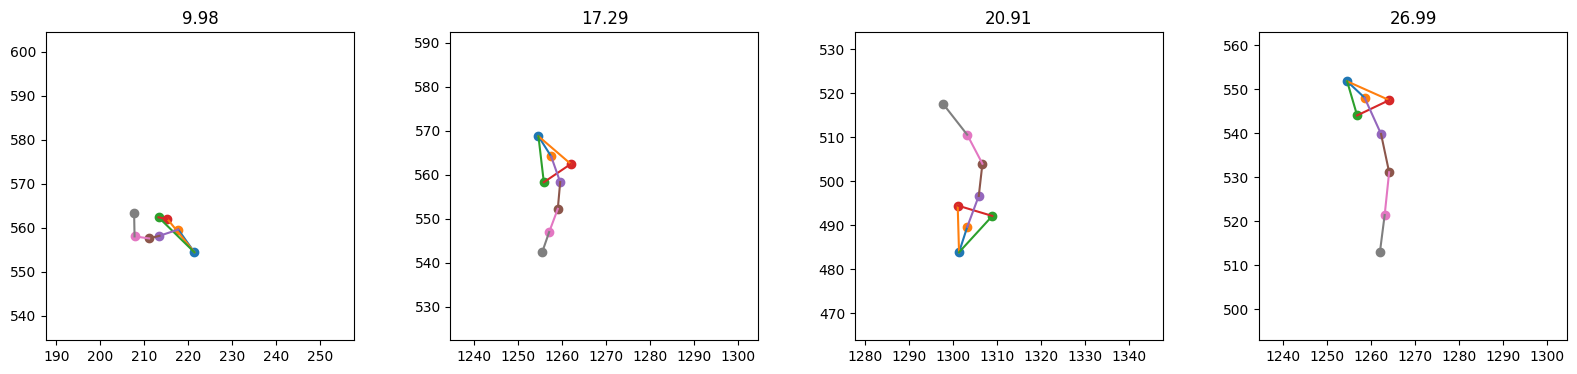

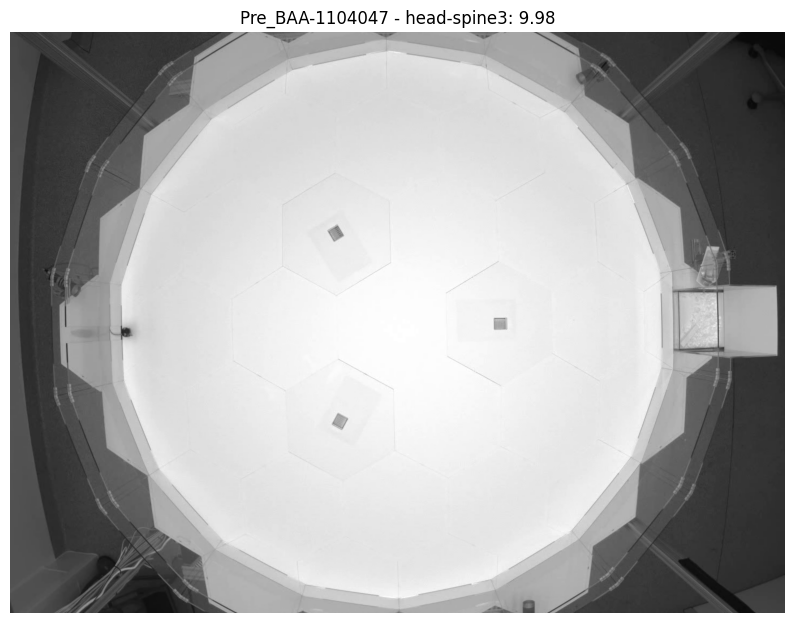

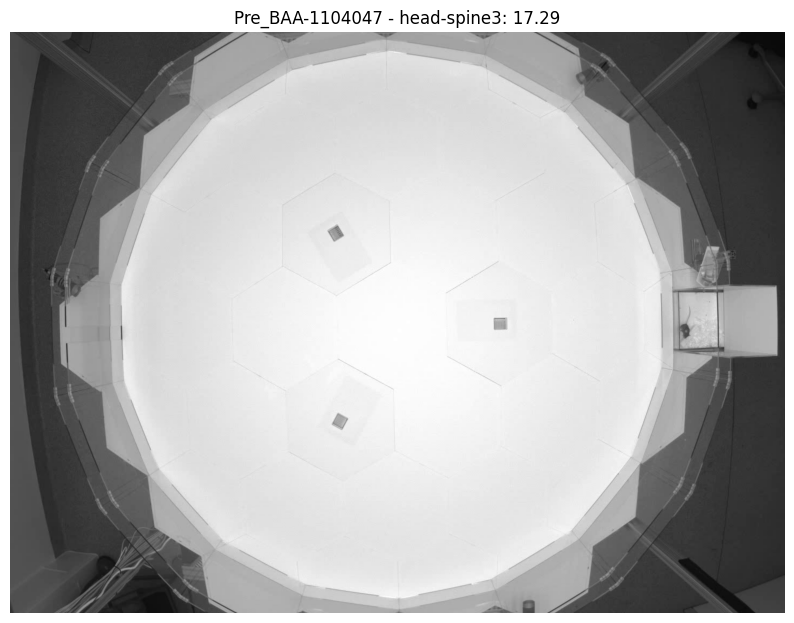

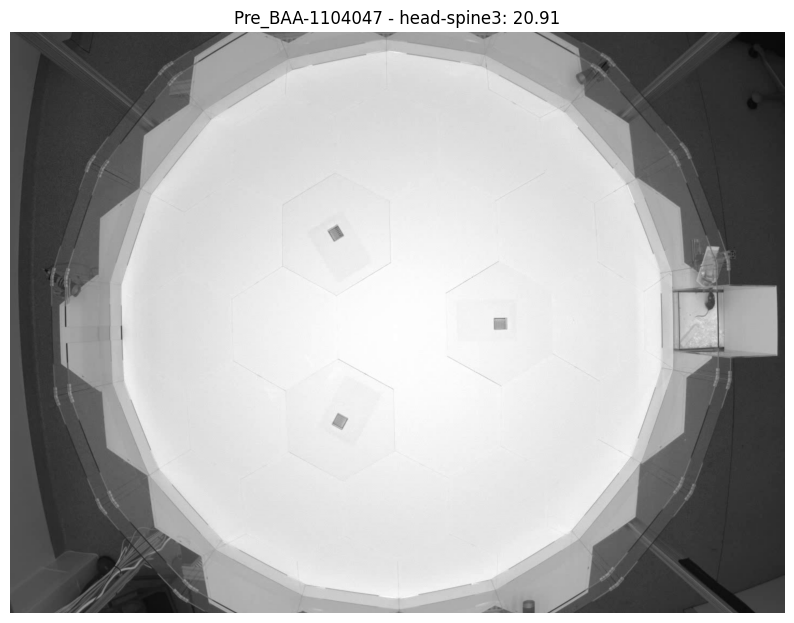

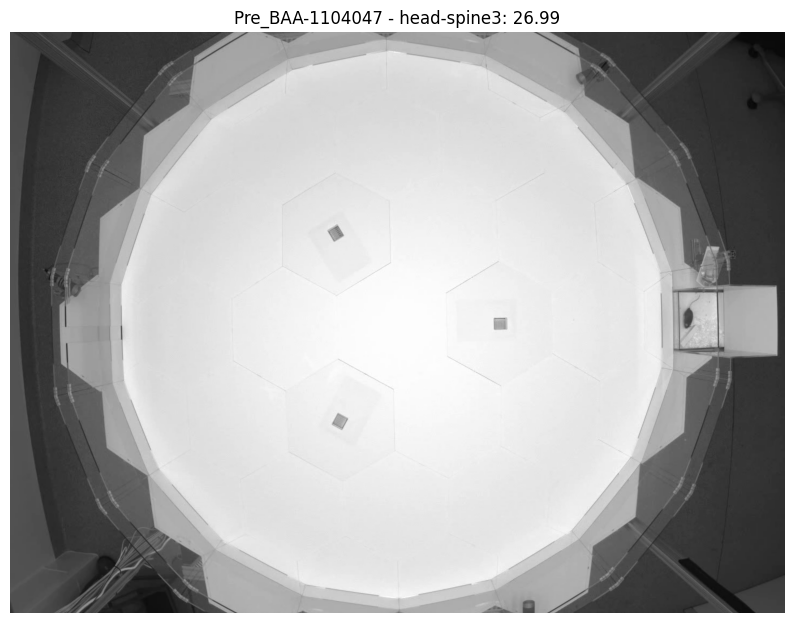

In [23]:
def Display_Body_Info(Mouse, property, nodes):
    def n_Cluster(variable):
        n_cluster = {
            'spine1-spine3': 3, 
            'head-spine3': 4, 
            'right_ear-spine3': 5,
            'left_ear-spine3': 5
        }
        return n_cluster[variable]
    
    def Get_Pose_Frame(variable, value_str, time):
        start, end = time, time + pd.Timedelta("0.2S")
        root = Mouse.root
        video_metadata = aeon.load(root, social02.CameraTop.Video, start=start, end=end)
        video_metadata.index = video_metadata.index.round("20L")
        frames = video.frames(video_metadata)
        first_frame = next(frames)
        #cv2.imwrite("../Images/Social_BodyInfo/" + variable + '/frames/' + Mouse_title + '_' + value_str + '.jpg', first_frame)
        
        rgb_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 8))
        plt.imshow(rgb_frame)
        plt.title(f"{Mouse_title} - {variable}: {value_str}")
        plt.axis('off')  # Hide axes
        plt.show()

    def DrawBody(data_x, data_y, axs):
        for k in range(len(nodes_name)): 
            axs.scatter(data_x[nodes_name[k]], data_y[nodes_name[k]])
        axs.plot([data_x['nose'],data_x['head']], [data_y['nose'],data_y['head']])
        axs.plot([data_x['left_ear'],data_x['nose']], [data_y['left_ear'],data_y['nose']])
        axs.plot([data_x['nose'],data_x['right_ear']], [data_y['nose'],data_y['right_ear']])
        axs.plot([data_x['left_ear'],data_x['right_ear']], [data_y['left_ear'],data_y['right_ear']])
        axs.plot([data_x['head'],data_x['spine1']], [data_y['head'],data_y['spine1']])
        axs.plot([data_x['spine1'],data_x['spine2']], [data_y['spine1'],data_y['spine2']])
        axs.plot([data_x['spine2'],data_x['spine3']], [data_y['spine2'],data_y['spine3']])
        axs.plot([data_x['spine3'],data_x['spine4']], [data_y['spine3'],data_y['spine4']])
        x_min, y_min = min(np.array(data_x)), min(np.array(data_y))
        axs.set_aspect('equal', 'box')
        axs.set_xlim(x_min-20, x_min+50)
        axs.set_ylim(y_min-20, y_min+50)
        return axs

    def DrawPoses(variable, center, d, axs):
        for j in range(len(center)):
            for i in range(len(data_x)):
                if abs(d[i] - center[j]) < 0.1: 
                    if np.any(np.isnan(np.array(data_x.iloc[i]))): continue
                    axs[j] = DrawBody(data_x.iloc[i],data_y.iloc[i], axs[j])
                    axs[j].set_title(str(round(center[j],2)))
                    break
        for j in range(len(center)):
            for i in range(len(data_x)):
                if abs(d[i] - center[j]) < 0.1: 
                    if np.any(np.isnan(np.array(data_x.iloc[i]))): continue
                    Get_Pose_Frame(variable, str(round(center[j],2)), time = times[i])
                    break
        return axs

    def DrawDistance(variable):
        data = mouse_pos[variable].to_numpy()
        kmeans = KMeans(n_clusters=n_Cluster(variable), random_state=0, n_init = 'auto')
        clusters = kmeans.fit_predict(data.reshape(-1, 1))
        center = np.sort(kmeans.cluster_centers_.T[0])
        
        fig, axs = plt.subplots(1,len(center), figsize = (len(center)*5,4))
        axs = DrawPoses(variable,center, data, axs)
        #plt.savefig('../Images/Social_BodyInfo/'+ variable + '/' + Mouse_title + '.png')
        plt.show()

    Mouse_title = Mouse.type + '_' + Mouse.mouse
    times = Mouse.mouse_pos.index
    mouse_pos = Mouse.mouse_pos
    
    variable = nodes[0]
    for i in range(1, len(nodes)): variable = variable + '-' + nodes[i]
    
    data_x = Mouse.body_data_x
    data_y = Mouse.body_data_y
    
    DrawDistance(variable)

Display_Body_Info(Mouse, property = 'distance', nodes = ['head', 'spine3'])

# **2. Display Kinematic Properties**

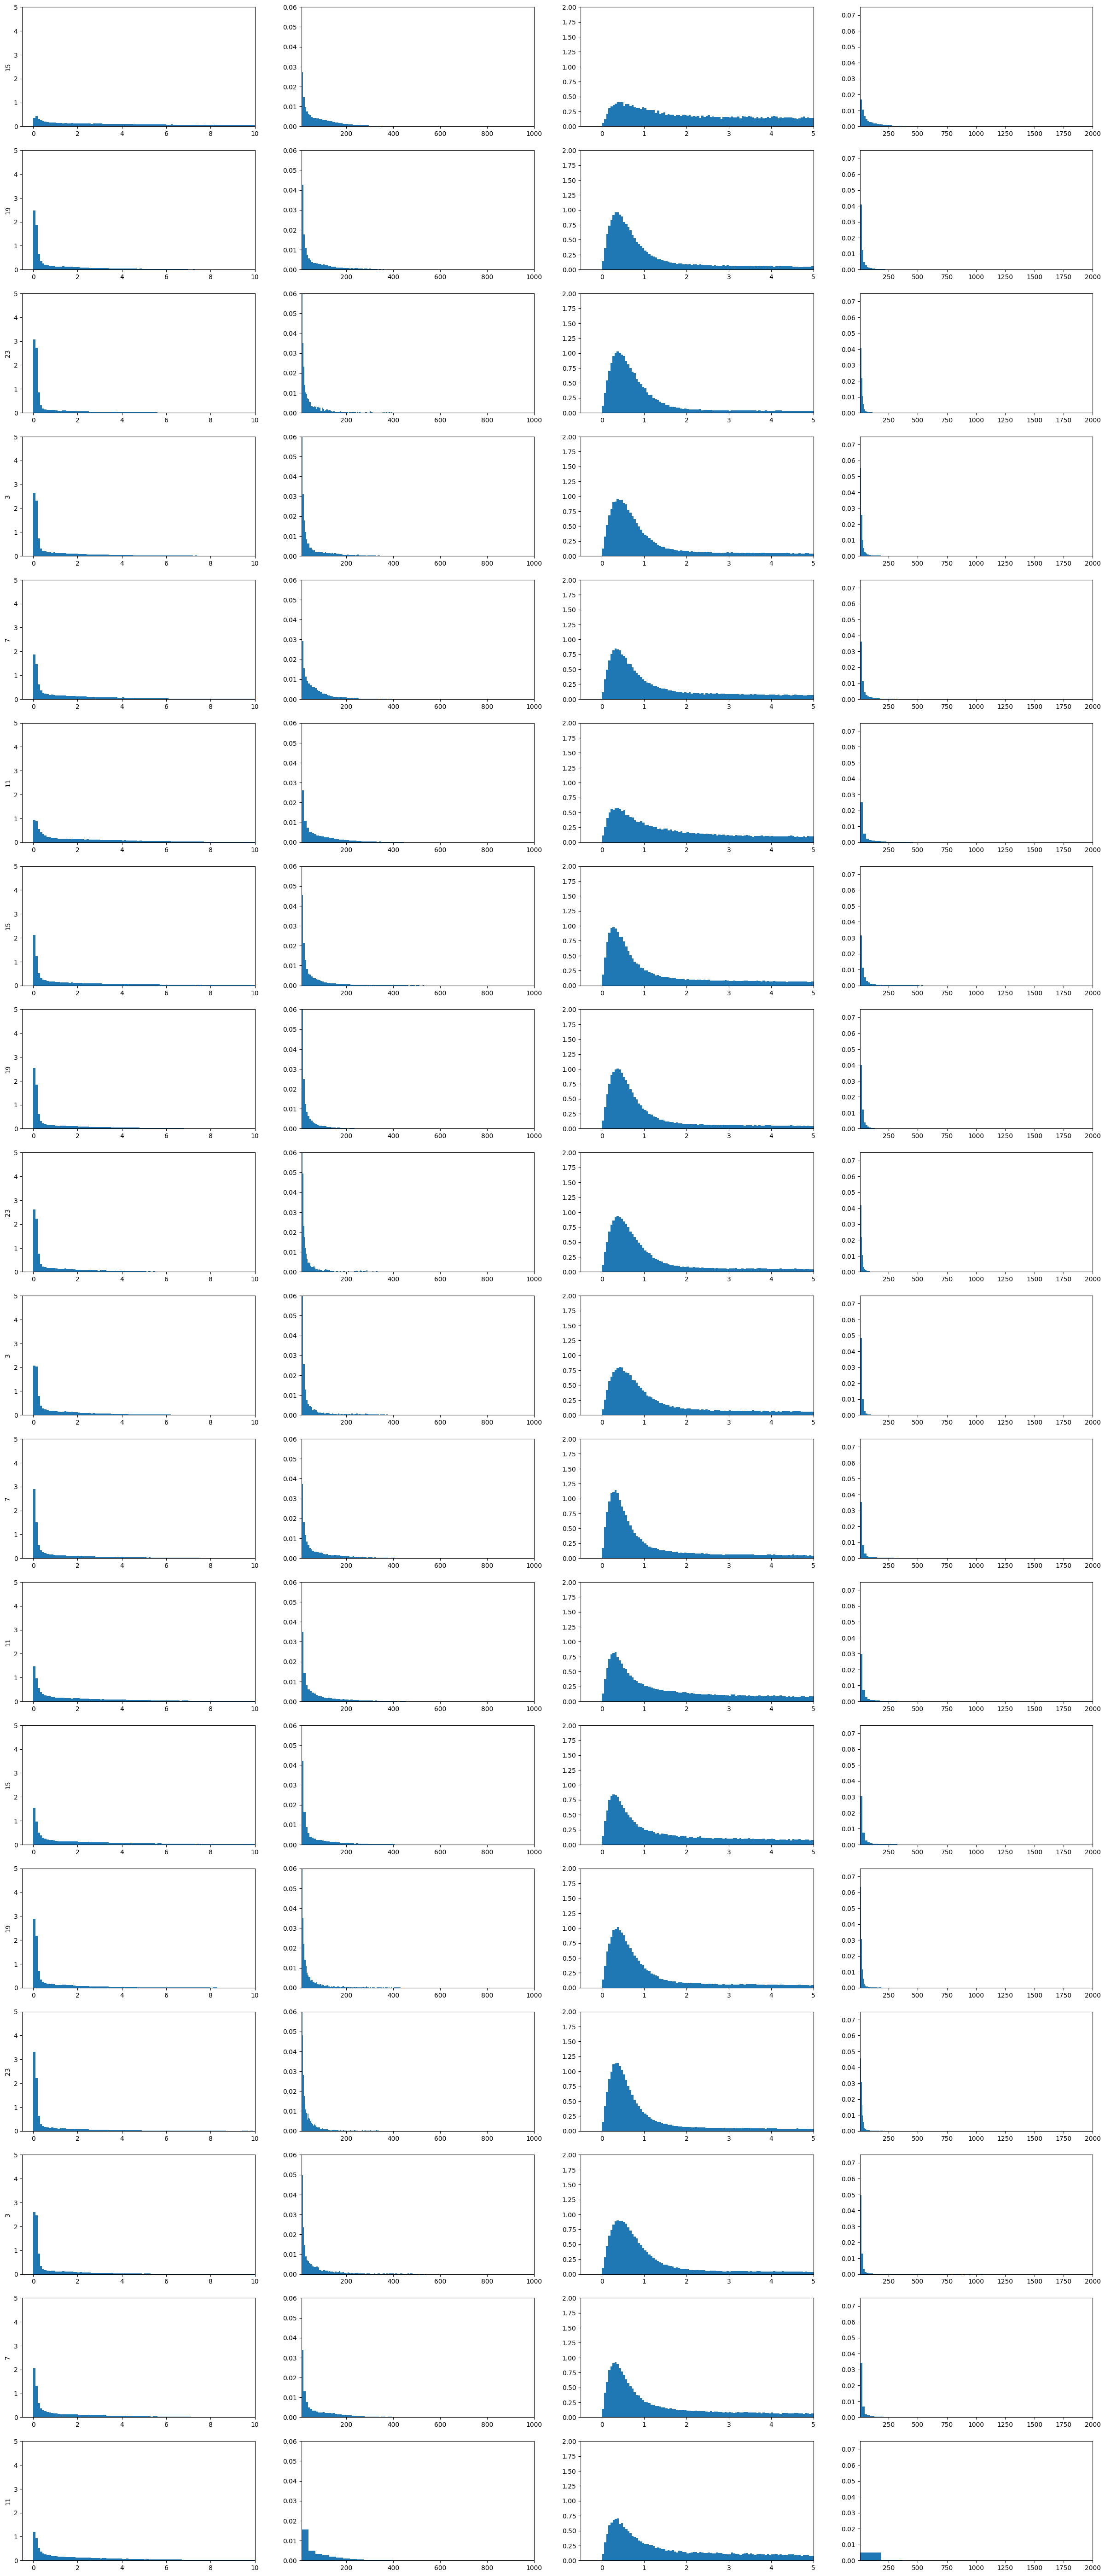

In [25]:
def Display_Kinematics_Distribution_Along_Time(Mouse):
    Mouse_title = Mouse.type + '_' + Mouse.mouse
    mouse_pos = Mouse.mouse_pos
    start, end = mouse_pos.index[0], mouse_pos.index[-1]
    starts, ends = [],[]
    while start < end:
        end_ = start + pd.Timedelta('4H')

        starts.append(start)
        ends.append(end_)
        start = end_ + pd.Timedelta('1S')

    n = len(starts)
    fig, axs = plt.subplots(n, 4, figsize = (30, 4*n))
    for i in range(n):
        df = mouse_pos[starts[i]:ends[i]]
        speed = df.smoothed_speed
        axs[i,0].hist(speed[speed<10], density = True, bins = 100)
        axs[i,0].set_xlim((-0.5,10))
        axs[i,0].set_ylim((0,5))
        axs[i,1].hist(speed[speed>10], density = True, bins = 100)
        axs[i,1].set_xlim((9.5,1000))
        axs[i,1].set_ylim((0,0.06))
        
        acce = df.smoothed_acceleration
        axs[i,2].hist(acce[acce<5], density = True, bins = 100)
        axs[i,2].set_xlim((-0.5,5))
        axs[i,2].set_ylim((0,2))
        axs[i,3].hist(acce[acce>5], density = True, bins = 100)
        axs[i,3].set_xlim((4.5,2000))
        axs[i,3].set_ylim((0, 0.075))
        
        axs[i,0].set_ylabel(starts[i].hour)
    #plt.savefig(file_path + Mouse_title+'.png')
    plt.show()
    
Display_Kinematics_Distribution_Along_Time(Mouse)

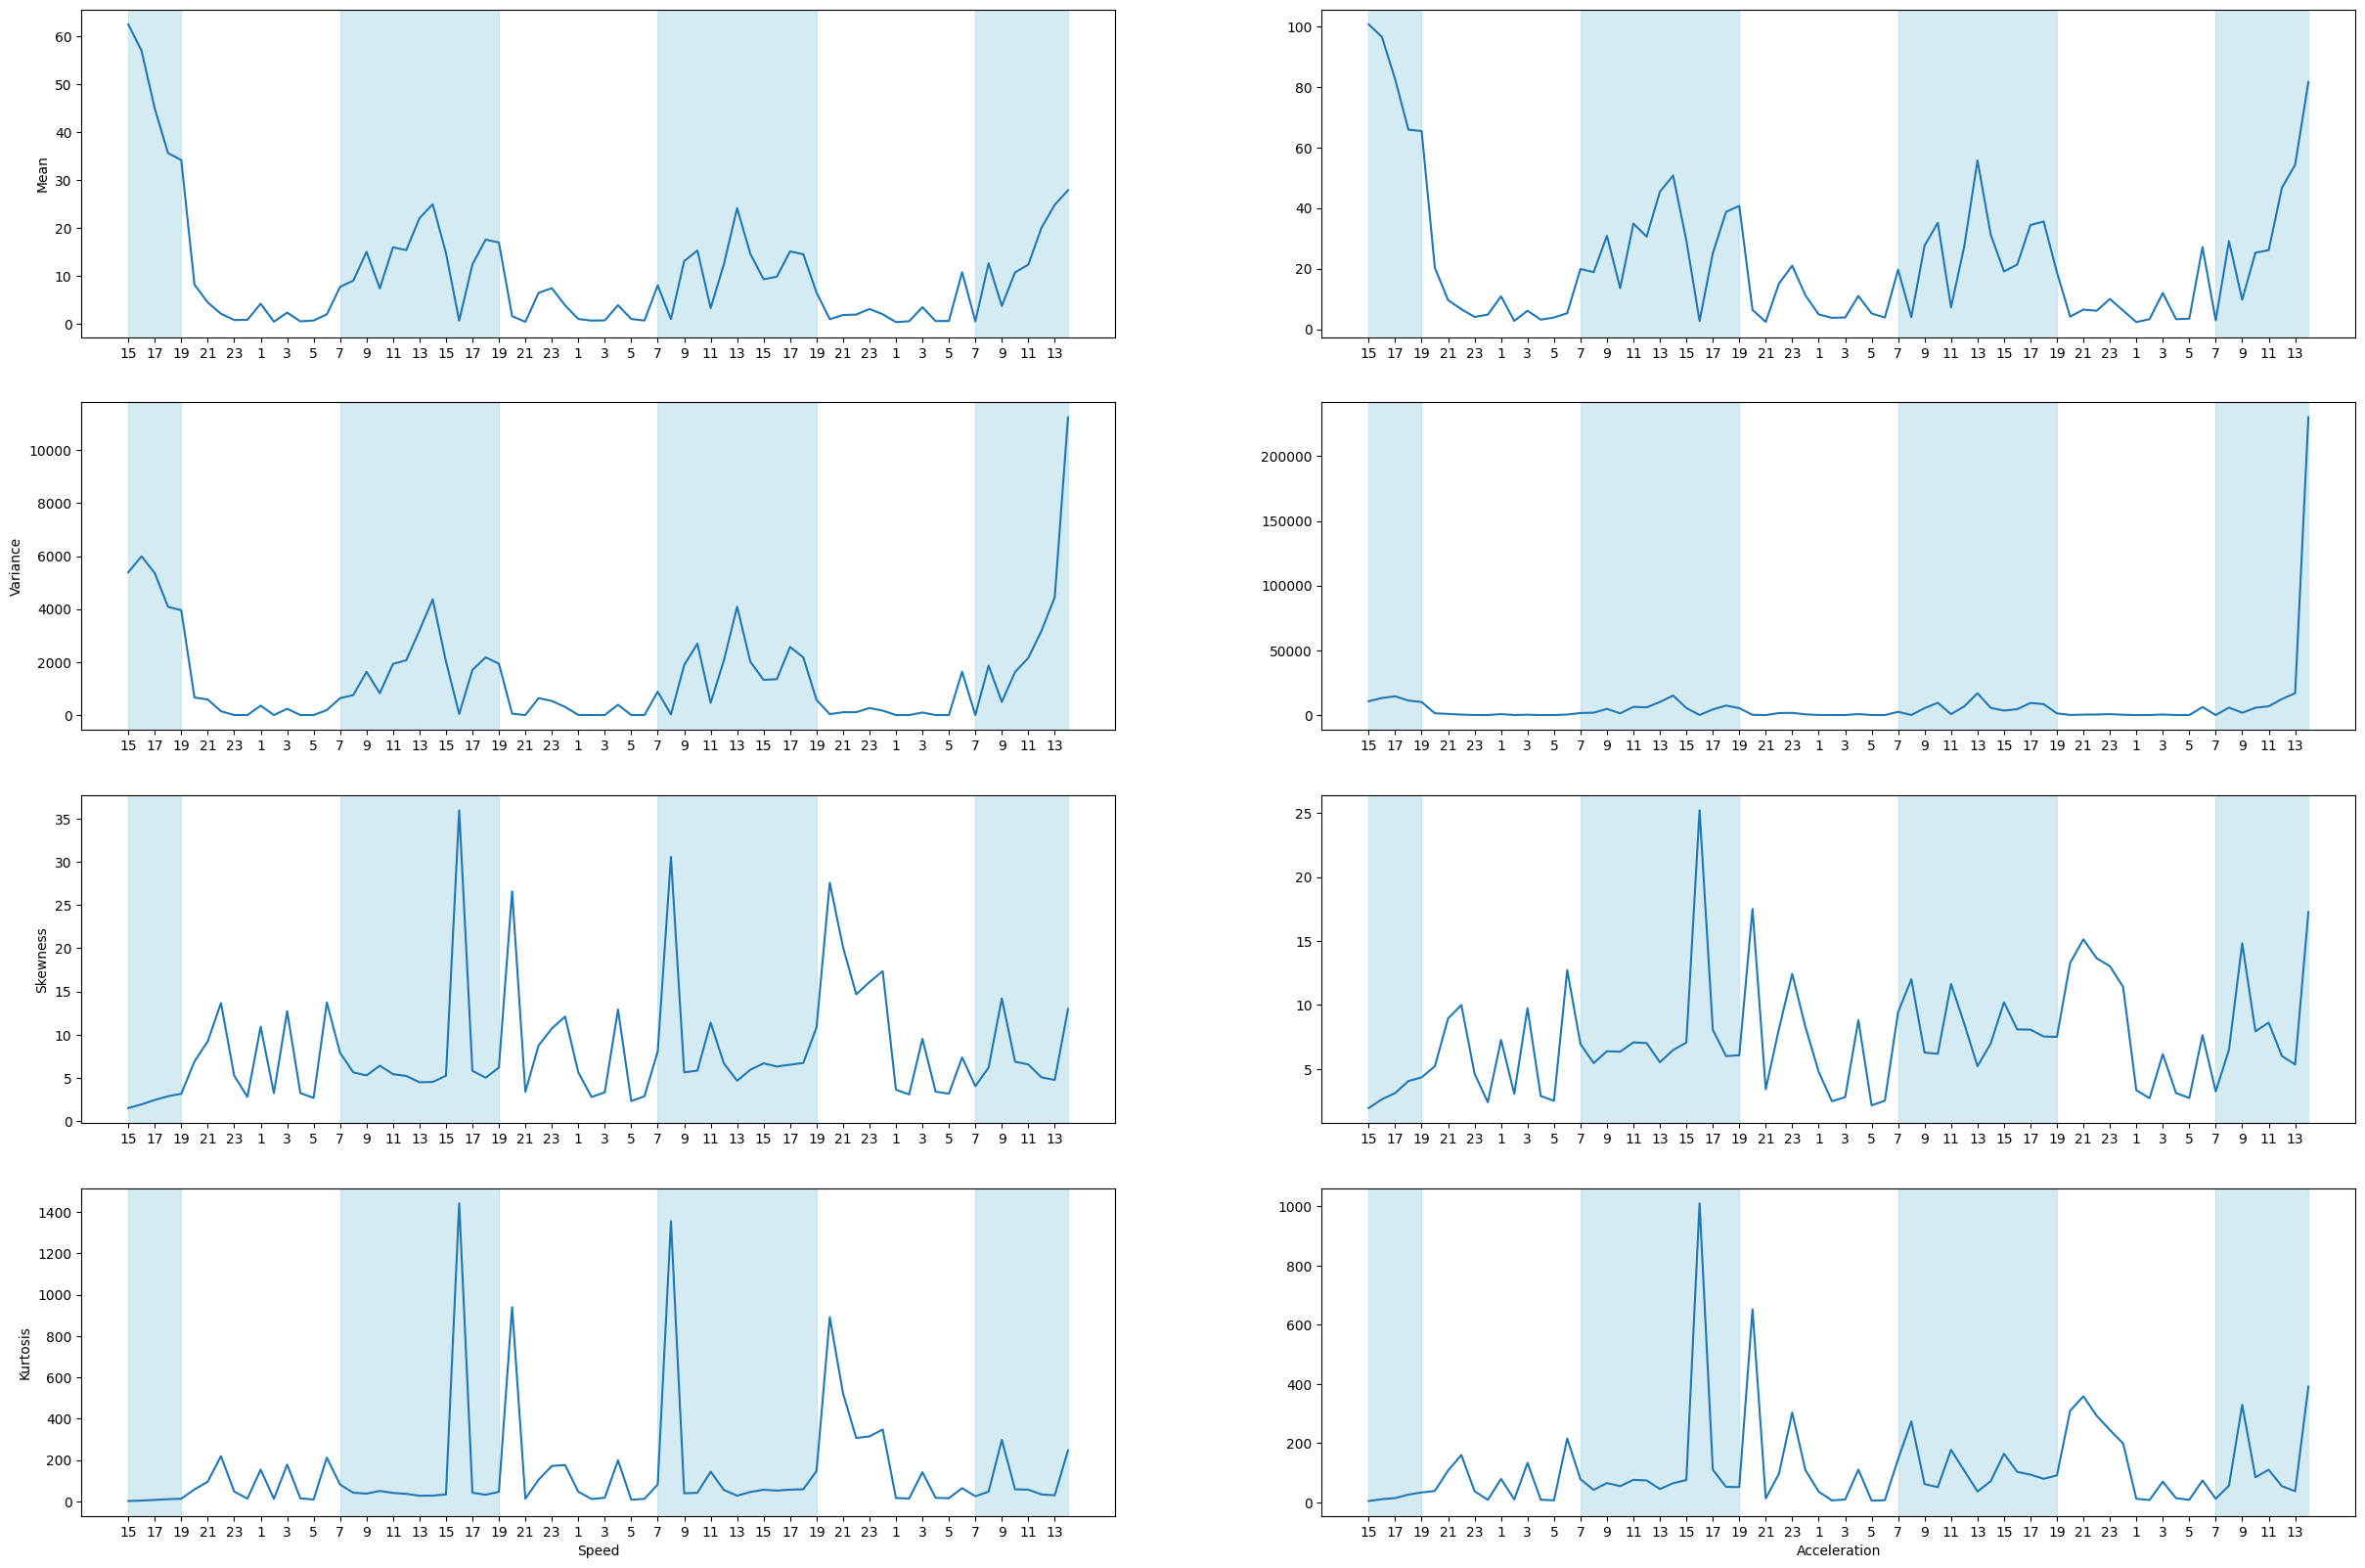

In [24]:
def Display_Kinematics_Properties_Along_Time(Mouse):   
    def Calculate_Properties(dist):
        mean = np.mean(dist)
        variance = np.var(dist)
        skewness = stats.skew(dist)
        kurtosis = stats.kurtosis(dist)
        return mean, variance, skewness, kurtosis

    Mouse_title = Mouse.type + '_' + Mouse.mouse
    mouse_pos = Mouse.mouse_pos
    start, end = mouse_pos.index[0], mouse_pos.index[-1]
    starts, ends = [],[]
    while start < end:
        if start.minute != 0:
            end_ = pd.Timestamp(year = start.year, month = start.month, day = start.day, hour = start.hour+1, minute=0, second=0)
        else: 
            end_ = start + pd.Timedelta('1H')

        starts.append(start)
        ends.append(end_)
        start = end_        
    
    Mean_V, Variance_V, Skewness_V, Kurtosis_V = [], [], [], []
    Mean_A, Variance_A, Skewness_A, Kurtosis_A = [], [], [], []
    Hour = []
    n = len(starts)
    
    CR = []
    for i in range(n):
        df = mouse_pos[starts[i]:ends[i]]
        speed = df.smoothed_speed
        mean, variance, skewness, kurtosis = Calculate_Properties(speed)
        Mean_V.append(mean)
        Variance_V.append(variance)
        Skewness_V.append(skewness)
        Kurtosis_V.append(kurtosis)
        
        acce = df.smoothed_acceleration
        mean, variance, skewness, kurtosis = Calculate_Properties(acce)
        Mean_A.append(mean)
        Variance_A.append(variance)
        Skewness_A.append(skewness)
        Kurtosis_A.append(kurtosis)
        
        Hour.append(starts[i].hour)
        if starts[i].hour == 7 or starts[i].hour == 19: CR.append(i)
    CR = np.array(CR)
    if starts[CR[0]].hour == 19: CR = np.concatenate((np.array([0]), CR))
    if starts[CR[-1]].hour == 7: CR = np.concatenate((CR, np.array([n-1])))
    
    N = np.arange(n)
    fis, axs = plt.subplots(4, 2, figsize = (30, 20))
    axs[0,0].plot(N, Mean_V)
    axs[0,0].set_ylabel('Mean')
    axs[1,0].plot(N, Variance_V)
    axs[1,0].set_ylabel('Variance')
    axs[2,0].plot(N, Skewness_V)
    axs[2,0].set_ylabel('Skewness')
    axs[3,0].plot(N, Kurtosis_V)
    axs[3,0].set_ylabel('Kurtosis')
    axs[0,1].plot(N, Mean_A)
    axs[1,1].plot(N, Variance_A)
    axs[2,1].plot(N, Skewness_A)
    axs[3,1].plot(N, Kurtosis_A)
    axs[3,0].set_xlabel('Speed')
    axs[3,1].set_xlabel('Acceleration')
    for i in range(4):
        for j in range(2):
            axs[i,j].set_xticks(N[::2], Hour[::2])
            for t in range(0,len(CR),2):
                axs[i,j].axvspan(CR[t],CR[t+1], color='lightblue', alpha=0.5)
    #plt.savefig(file_path + Mouse_title+'.png')
    #print('Display_Kinematics_Properties_Along_Time Completed')
    plt.show()

Display_Kinematics_Properties_Along_Time(Mouse)

# **3. Display HMM Results**

In [29]:
Mouse.hmm.n_state = 20
Mouse.hmm.feature = 'Kinematics_and_Body'
Mouse.hmm.Fit_Model(n_state = 20, feature = 'Kinematics_and_Body')
Mouse.hmm.Get_TransM(n_state = 20, feature = 'Kinematics_and_Body')
Mouse.hmm.Get_States()

print(Mouse.hmm.features)
print(Mouse.hmm.parameters)

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


: 

## ***I. Transition Matrix***

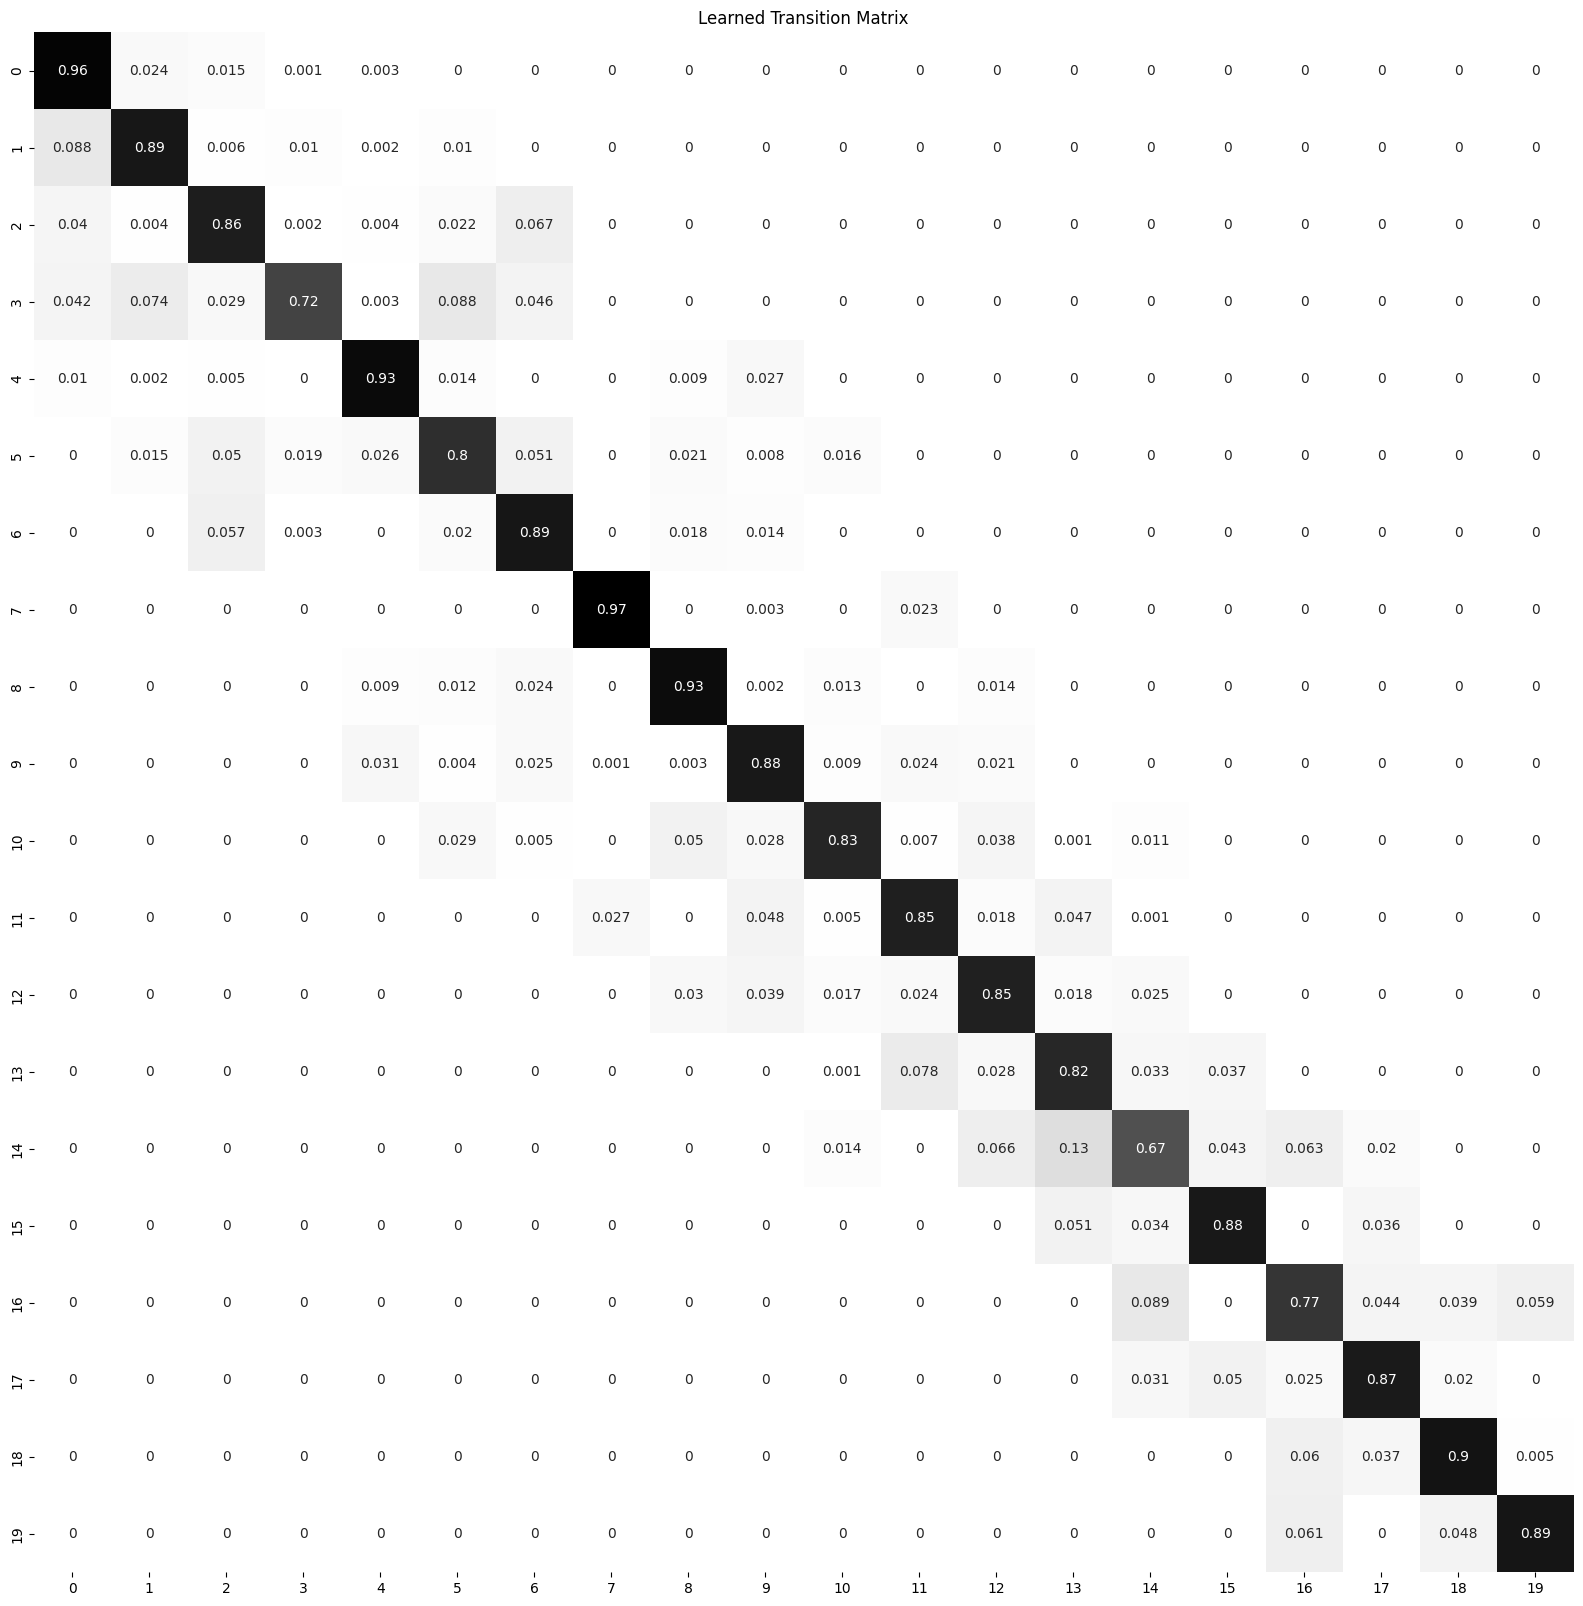

In [28]:
def Display_HMM_TransM(Mouse):
    Mouse_title = Mouse.type + '_' + Mouse.mouse
    TransM = Mouse.hmm.TransM
    annot_array = np.array([[round(item, 3) for item in row] for row in TransM])
    fig, axs = plt.subplots(1,1, figsize=(len(TransM), len(TransM)))
    sns.heatmap(TransM, cmap='binary', ax = axs, square = 'True', cbar = False, annot=annot_array)
    axs.set_title("Learned Transition Matrix") 
    plt.show()

Display_HMM_TransM(Mouse)

## ***II. States (in One Day)***

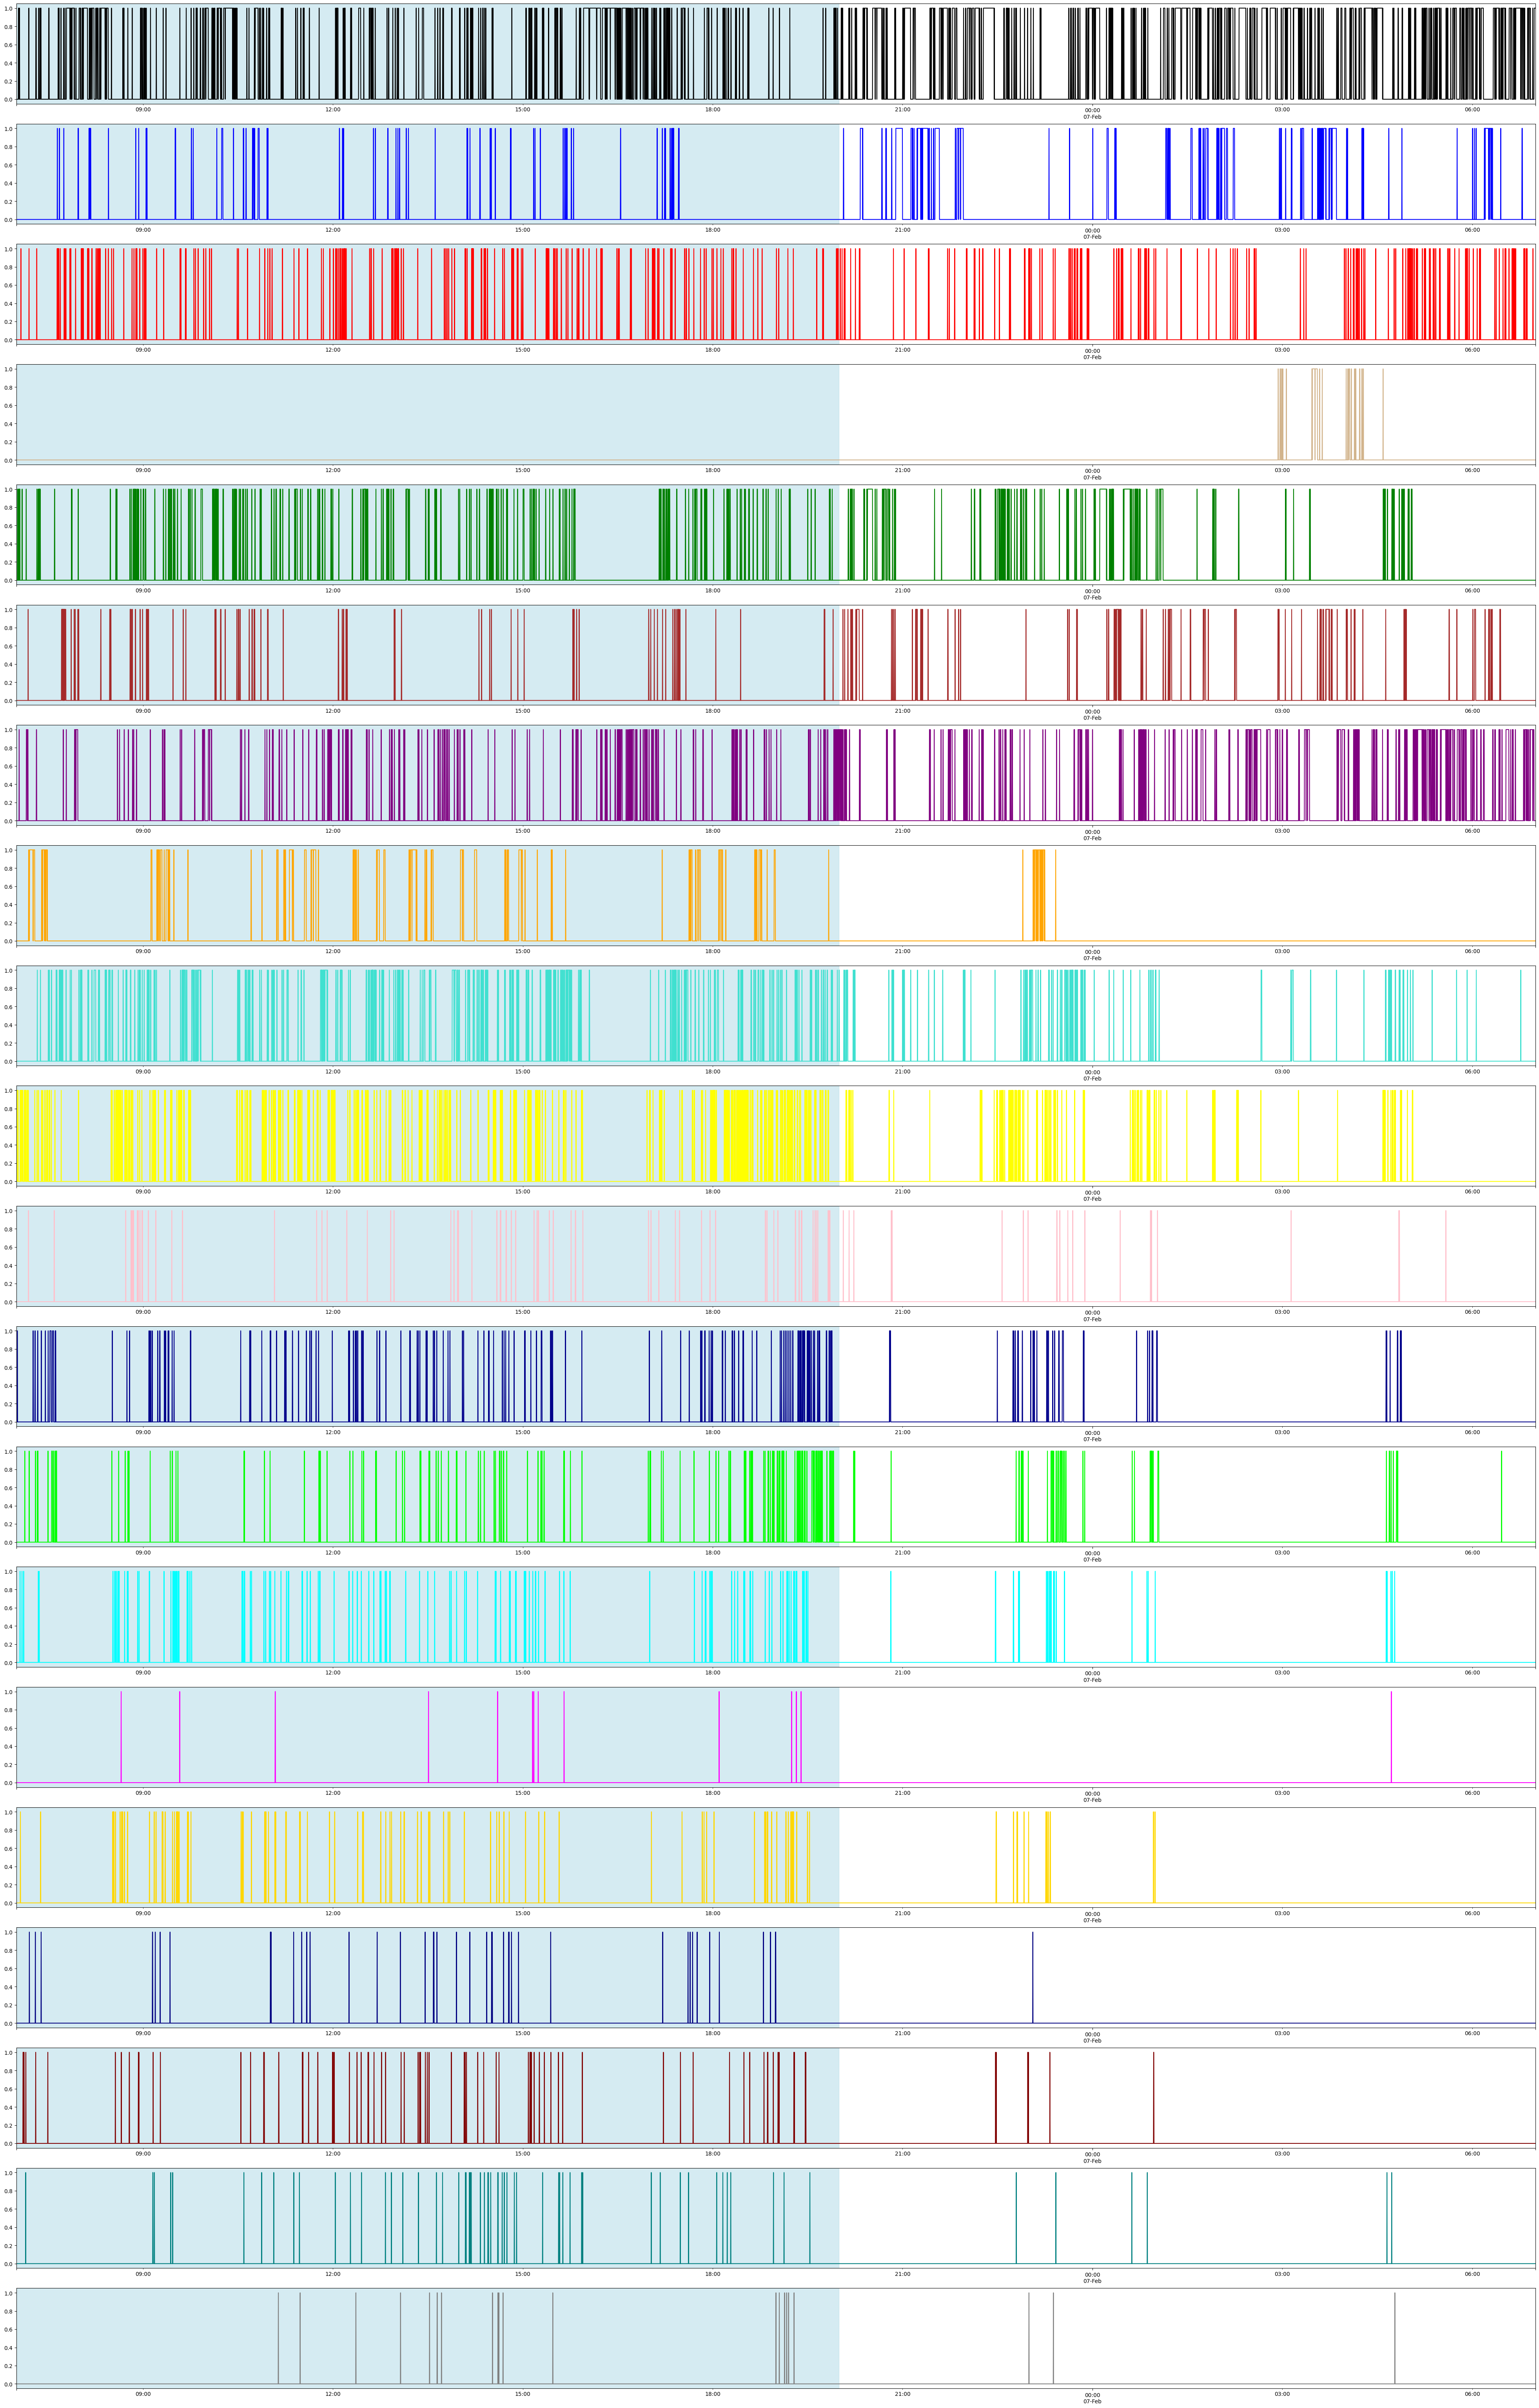

In [29]:
def Display_HMM_States_Along_Time(Mouse):
    Mouse_title = Mouse.type + '_' + Mouse.mouse
    mouse_pos = Mouse.mouse_pos
    N = Mouse.hmm.n_state
    states = Mouse.hmm.states
    start, end = Mouse.active_chunk[0], Mouse.active_chunk[1]
    
    mouse_pos['state'] = pd.Series(states, index = mouse_pos.index)
    mouse_pos = mouse_pos[start:end]
    
    states_prob = Mouse.hmm.process_states.State_Dominance(mouse_pos, time_seconds = 10)
    states_prob['CR'] = 0
    CR_index_1 = states_prob[states_prob.index.hour < 7].index
    CR_index_2 = states_prob[states_prob.index.hour > 19].index
    CR_index = CR_index_1.union(CR_index_2).sort_values()
    states_prob.loc[CR_index, 'CR'] = 1
    groups = states_prob['CR'].ne(states_prob['CR'].shift()).cumsum()
    zero_groups = states_prob[states_prob['CR'] == 0].groupby(groups).groups
    zero_groups = list(zero_groups.values())

    START, END = [],[]
    for i in range(len(zero_groups)):
        START.append(zero_groups[i][0])
        END.append(zero_groups[i][-1])

    N = max(states) + 1
    fig, axs = plt.subplots(N, 1, figsize=(50, 4*N-1))
    for i in range(N):
        states_prob[i].plot(color = color_names[i], ax = axs[i])
        for t in range(len(START)):
            axs[i].axvspan(START[t],END[t], color='lightblue', alpha=0.5)
    plt.show()

Display_HMM_States_Along_Time(Mouse) 

## ***III. Features of Each State***

In [30]:
def CollectData_Single(mouse_pos):
    x, y, speed, acce, r, spine1_spine3, head_spine3, right_ear_spine3, left_ear_spine3 = [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)]
    for i in range(N):
        x[i] =  mouse_pos['smoothed_position_x'][states==i]
        y[i] = mouse_pos['smoothed_position_y'][states==i]
        speed[i] = mouse_pos['smoothed_speed'][states==i]
        acce[i] = mouse_pos['smoothed_acceleration'][states == i]
        r[i] = mouse_pos['r'][states == i]
        spine1_spine3[i] = mouse_pos['spine1-spine3'][states == i]
        head_spine3[i] = mouse_pos['head-spine3'][states == i]
        right_ear_spine3[i] = mouse_pos['right_ear-spine3'][states == i]
        left_ear_spine3[i] = mouse_pos['left_ear-spine3'][states == i]
    return x, y, speed, acce, r, spine1_spine3, head_spine3, right_ear_spine3, left_ear_spine3

Mouse_title = Mouse.type + '_' + Mouse.mouse
mouse_pos = Mouse.mouse_pos
states = Mouse.hmm.states
N = Mouse.hmm.n_state
mouse_pos['state'] = pd.Series(states, index = mouse_pos.index)

x, y, speed, acce, r, spine1_spine3, head_spine3, right_ear_spine3, left_ear_spine3 = CollectData_Single(mouse_pos)

### ***I. Positions***

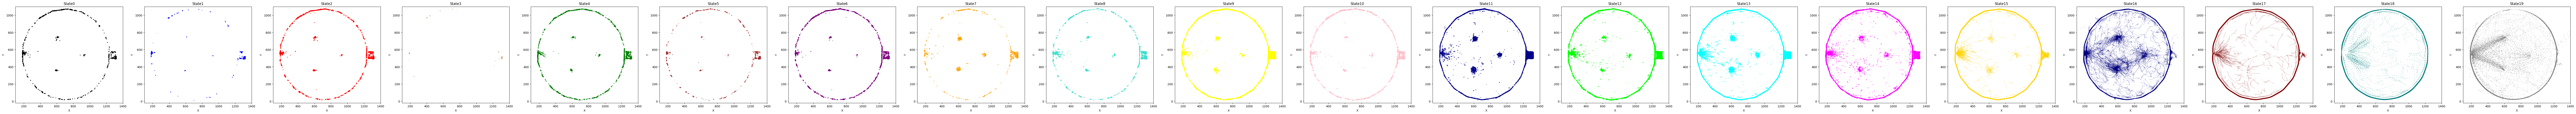

In [42]:
def PlotPosition(x, y):
    fig, axs = plt.subplots(1, N, figsize = (N*8-2,6))
    for i in range(N):
        axs[i].scatter(x[i], y[i], color = color_names[i], s = 2, alpha = 0.2)
        axs[i].set_xlim((100,1400))
        axs[i].set_ylim((-20,1100))
        axs[i].set_title('State' + str(i))
        axs[i].set_xlabel('X')
        axs[i].set_ylabel('Y')
    plt.show()

PlotPosition(x, y)

### ***II. Parameter Features***

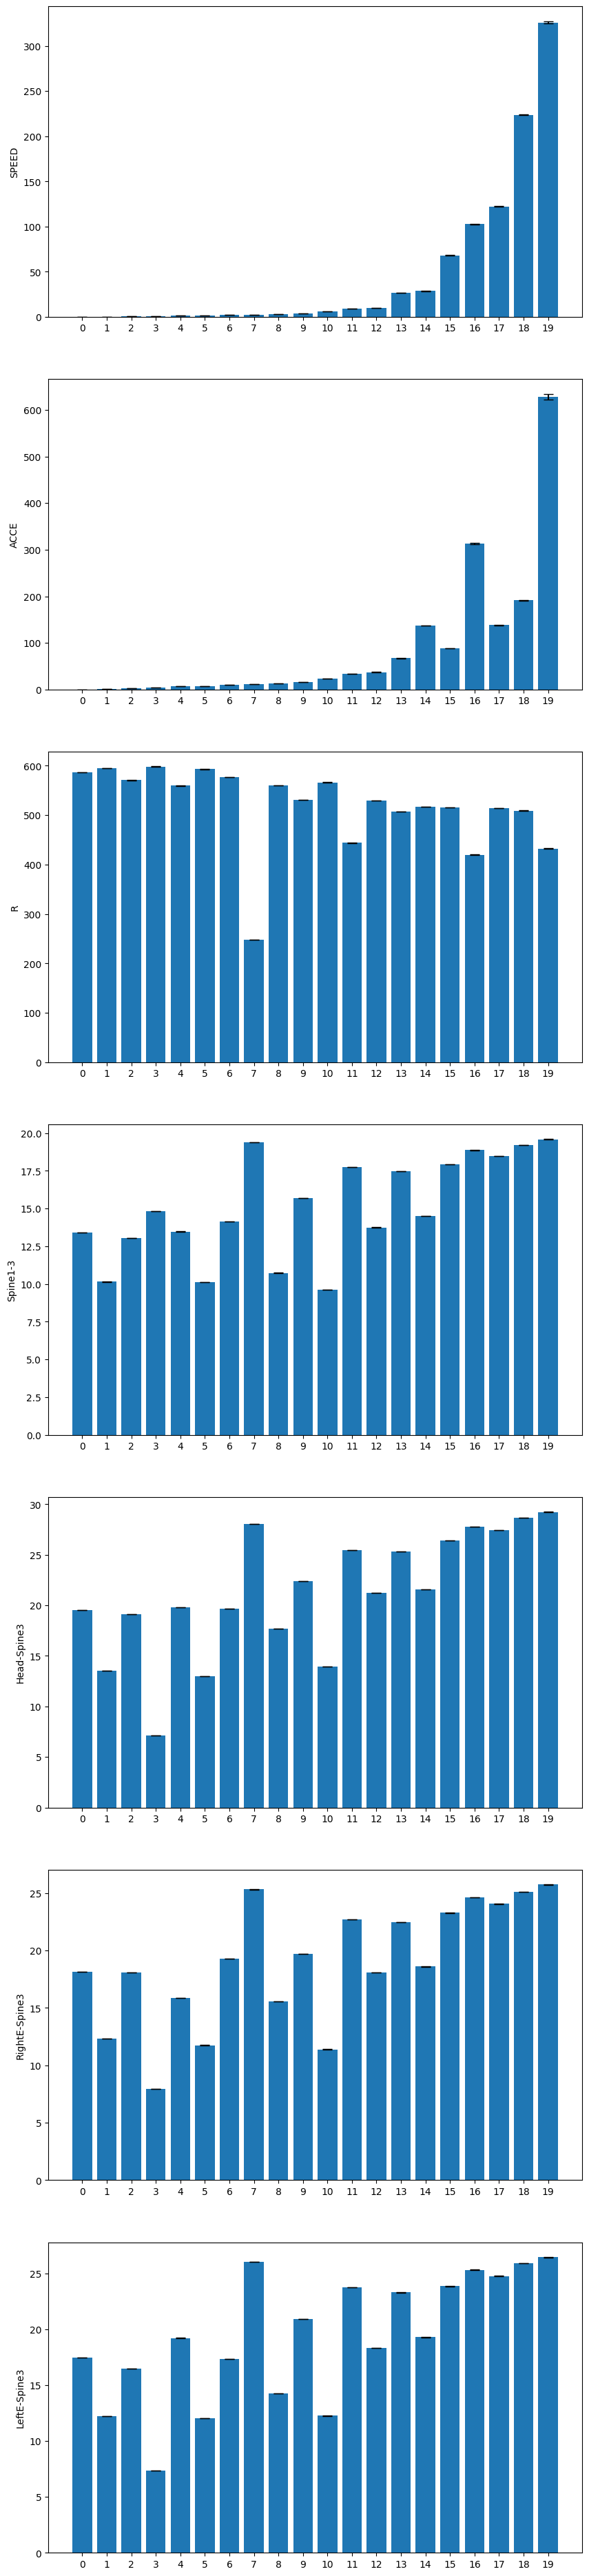

In [43]:
def PlotFeatures(DATA, FEATURE):
    fig, axs = plt.subplots(len(FEATURE), 1, figsize = (10, len(FEATURE)*7-1))
    for data, i in zip(DATA, range(len(DATA))):
        means = [np.mean(arr) for arr in data]
        var = [np.std(arr)/np.sqrt(len(arr)) for arr in data]
        axs[i].bar(range(N), means, yerr=var, capsize=5)
        axs[i].set_xticks(range(0, N), [str(j) for j in range(N)])
        axs[i].set_ylabel(FEATURE[i])
    plt.show()
    
PlotFeatures(DATA = [speed, acce, r, spine1_spine3, head_spine3, right_ear_spine3, left_ear_spine3], FEATURE = ['SPEED', 'ACCE', 'R', 'Spine1-3', 'Head-Spine3', 'RightE-Spine3', 'LeftE-Spine3'])

## ***III. Characterisation of Events***

In [51]:
def Characterize_Timepoints(event_name, Events, left_seconds, right_seconds, file_name):
    STATES = Mouse.hmm.process_states.Event_Triggering(mouse_pos, Events, left_seconds, right_seconds, 'state')
    X = Mouse.hmm.process_states.Event_Triggering(mouse_pos, Events, left_seconds, right_seconds, 'smoothed_position_x')
    Y = Mouse.hmm.process_states.Event_Triggering(mouse_pos, Events, left_seconds, right_seconds, 'smoothed_position_y')
    
    fig, axs = plt.subplots(1, 1, figsize=(10, 16))
    sns.heatmap(STATES,cmap=cmap, ax=axs, vmin=0, vmax = N-1, cbar = True)
    axs.set_aspect('auto')
    axs.set_xticks([10*left_seconds])
    axs.set_xticklabels([event_name], rotation = 0)
    axs.set_ylabel("Events")
    axs.set_yticks([])
    plt.show()
    
    fig, axs = plt.subplots(1, 1, figsize=(20, 20))
    mask = ~np.isnan(STATES[0])
    for i in range(len(STATES)):
        colors = np.array(color_names)[STATES[i][mask].astype(int)]
        x = X[i][mask]
        y = Y[i][mask]
        dx = np.diff(x)
        dy = np.diff(y)
        axs.quiver(x[:-1], y[:-1], dx, dy, color=colors[:-1], 
                angles='xy', scale_units='xy', scale=1.1, 
                width=0.001, headwidth=3, headlength=3)
    axs.set_aspect('equal')
    axs.set_xlim((100,1400))
    axs.set_ylim((-20,1100))
    plt.show()

    AVE_STATES = []
    for k in np.arange(N):
        index = STATES == k
        states = index*1
        AVE_STATES.append(np.mean(states, axis = 0))
    AVE_STATES = np.array(AVE_STATES)
    fig, axs = plt.subplots(1, 1, figsize=(10, 4))
    for i in range(AVE_STATES.shape[0]):
        color = color_names[i]
        rgba_color = plt.cm.colors.to_rgba(color)
        for j in range(AVE_STATES.shape[1]):
            if np.isnan(AVE_STATES[i, j]):
                axs.add_patch(plt.Rectangle((j, N-1-i), 0.1, 1, color=plt.cm.colors.to_rgba('black'), alpha=1, linewidth=0))
            else:
                axs.add_patch(plt.Rectangle((j, N-1-i), 1, 1, color=rgba_color, alpha=AVE_STATES[i, j], linewidth=0))
    axs.set_aspect('auto')
    axs.set_xticks([10*left_seconds])
    axs.set_xticklabels([event_name], rotation = 0)
    axs.set_ylabel("States")
    axs.set_yticks(np.arange(N) + 0.5)
    axs.set_yticklabels(np.arange(N-1,-1,-1))
    axs.set_xlim(0, AVE_STATES.shape[1])
    axs.set_ylim(0, AVE_STATES.shape[0])
    plt.show()

Mouse_title = Mouse.type + '_' + Mouse.mouse
mouse_pos = Mouse.mouse_pos
states = Mouse.hmm.states
N = Mouse.hmm.n_state

Pellets = Mouse.arena.pellets.index
Visits = Mouse.arena.visits.dropna(subset=['speed'])
Starts = Visits['start']
Ends = Visits['end']
Entry = Mouse.arena.entry 

mouse_pos['state'] = pd.Series(states, index = mouse_pos.index)

colors = sns.xkcd_palette(color_names[0:N])
cmap = gradient_cmap(colors)

### ***i. Enter Arena***

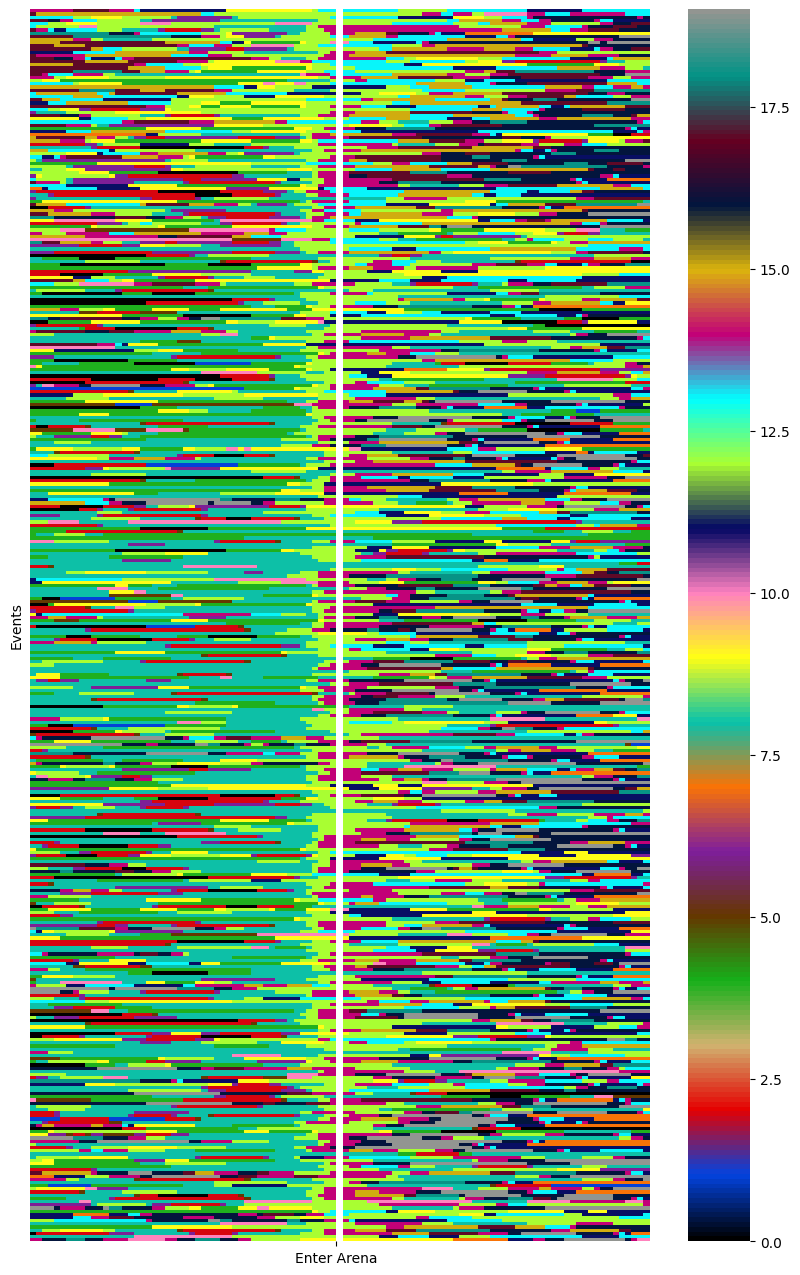

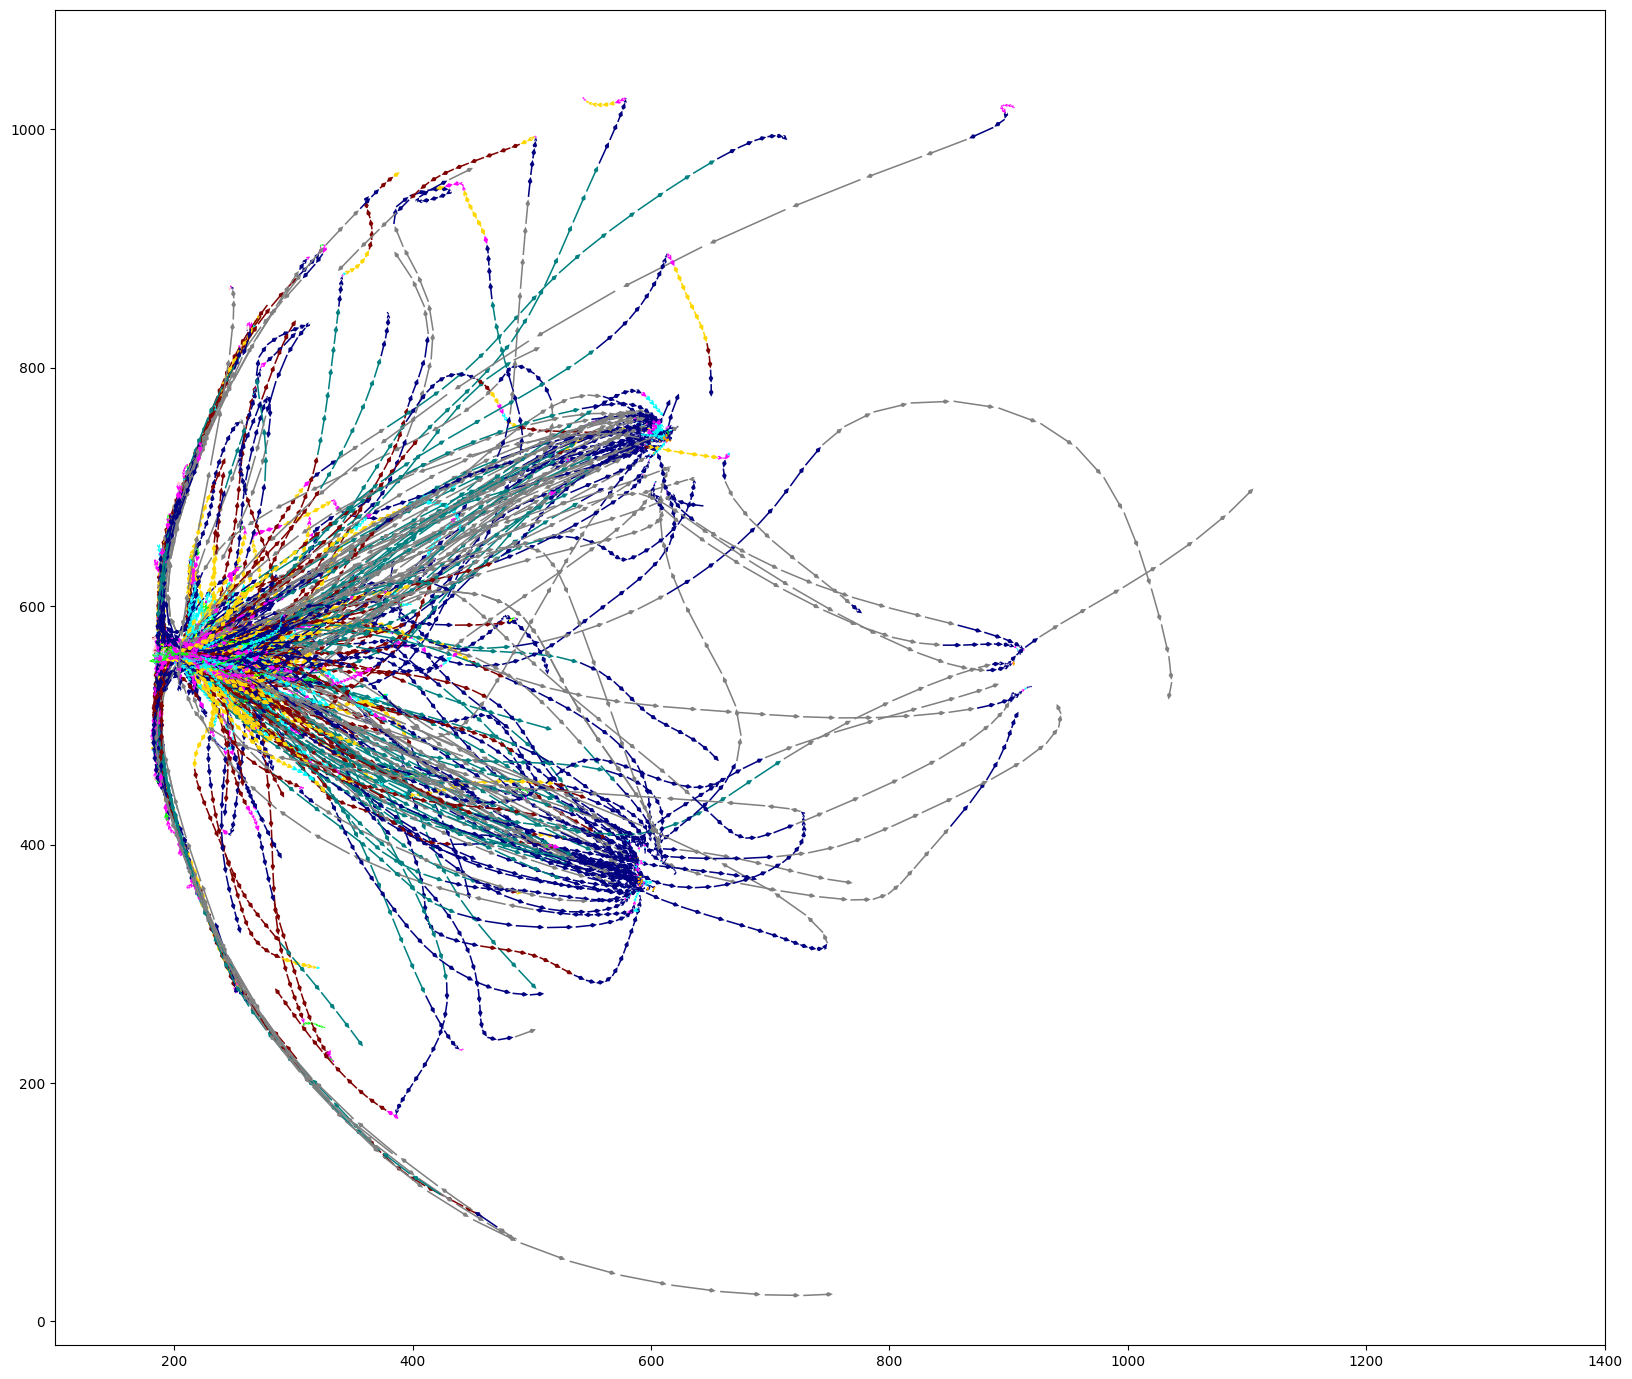

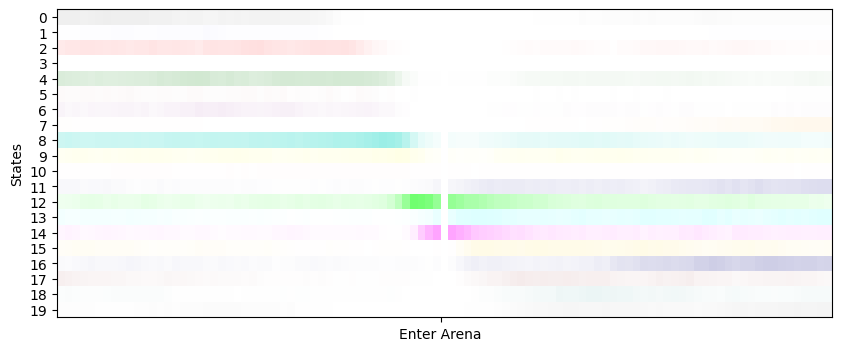

In [52]:
Characterize_Timepoints('Enter Arena', Entry, left_seconds = 5, right_seconds = 5, file_name = 'EnterArena')

### ***ii. Enter Patch***

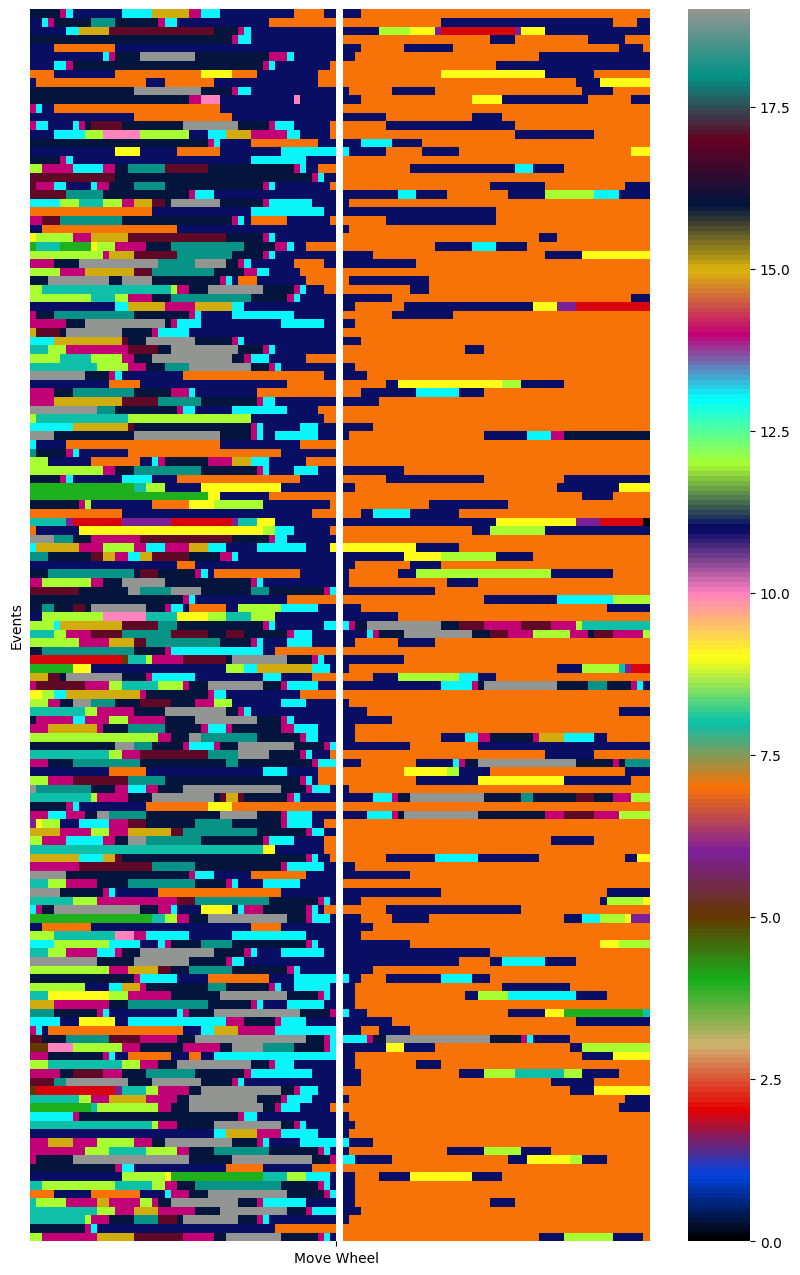

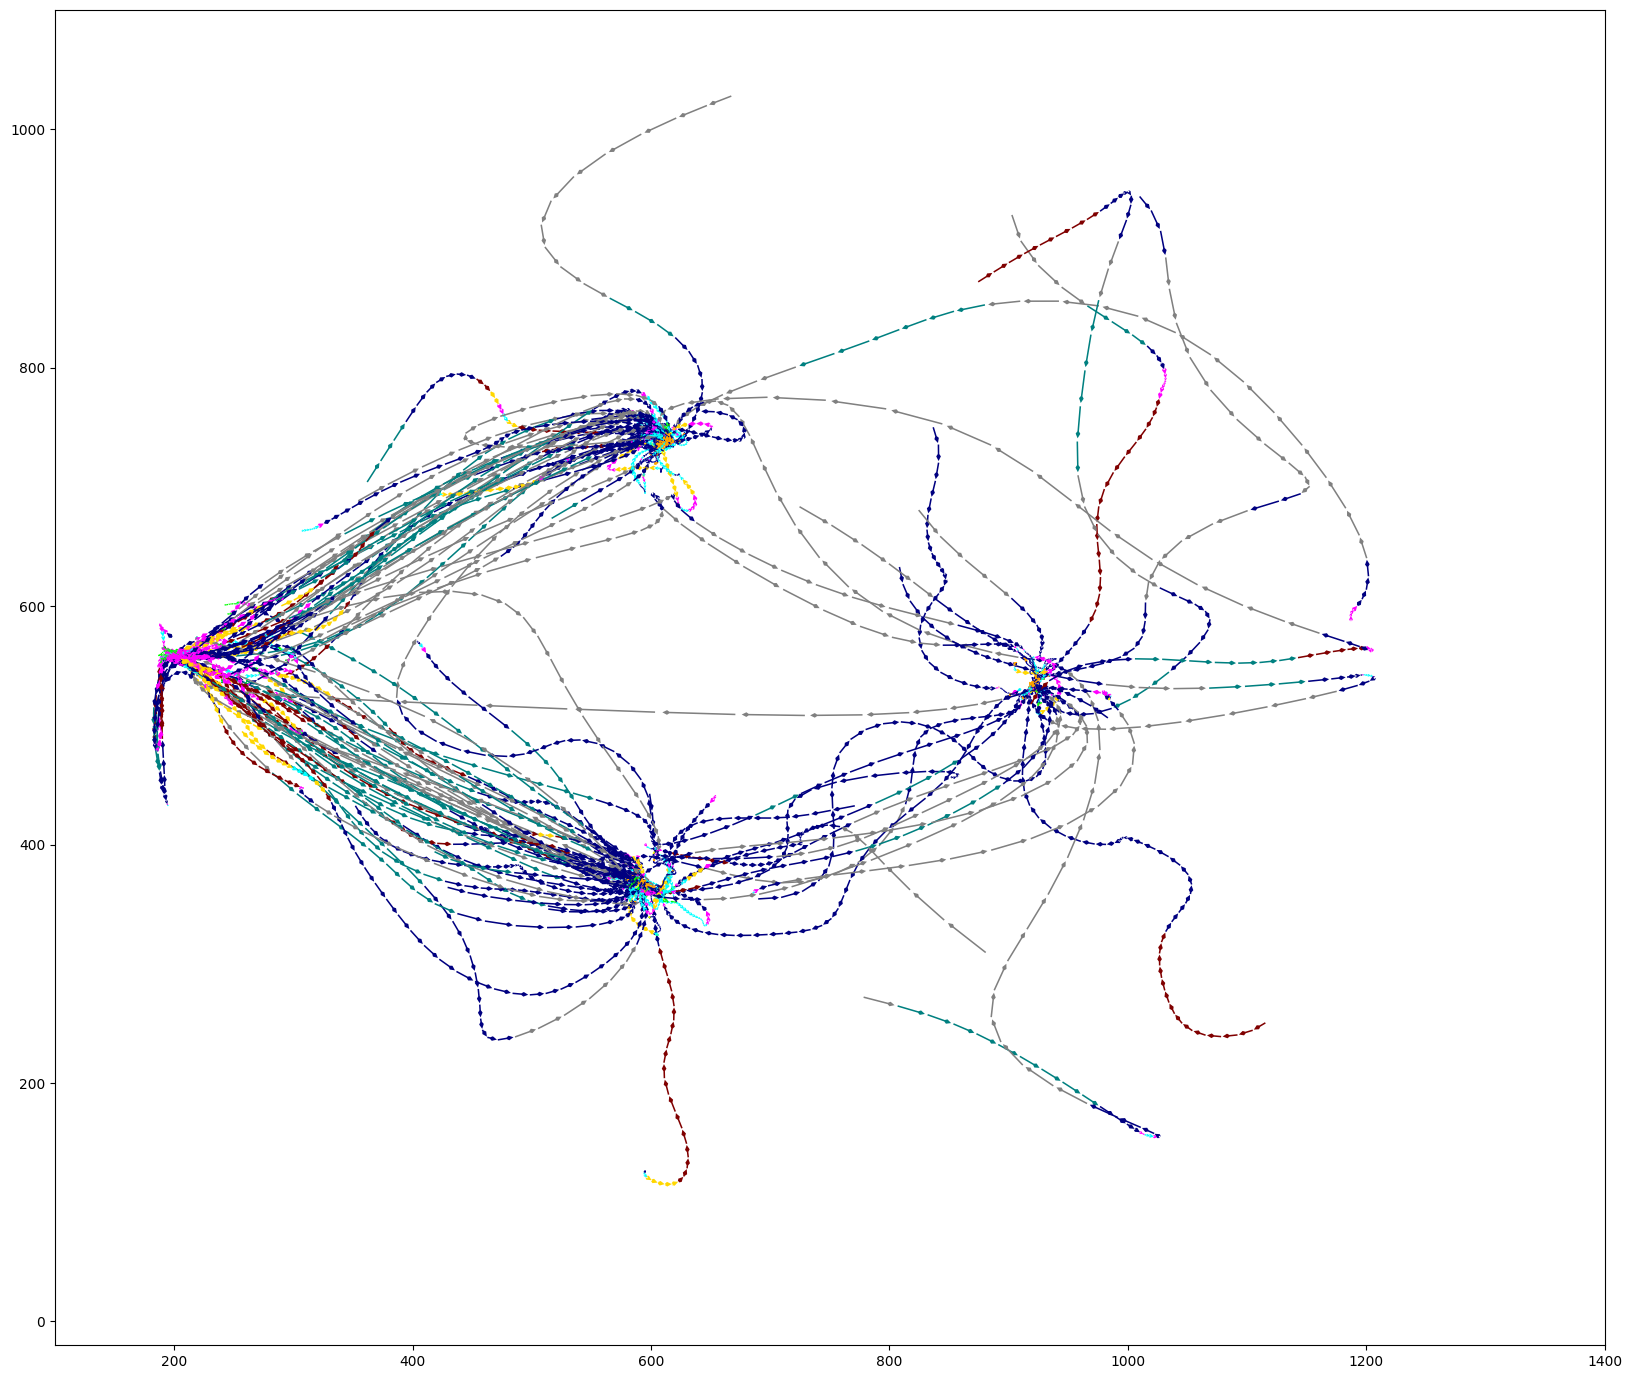

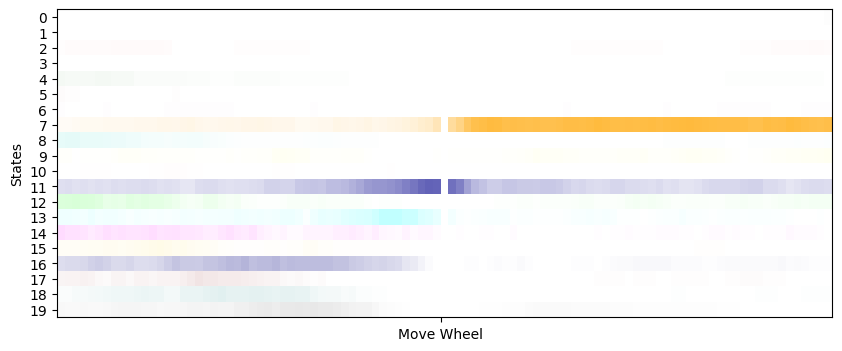

In [53]:
Characterize_Timepoints('Move Wheel', Starts, left_seconds = 5, right_seconds = 5, file_name = 'EnterVisit')

### ***iii. Leave Patch***

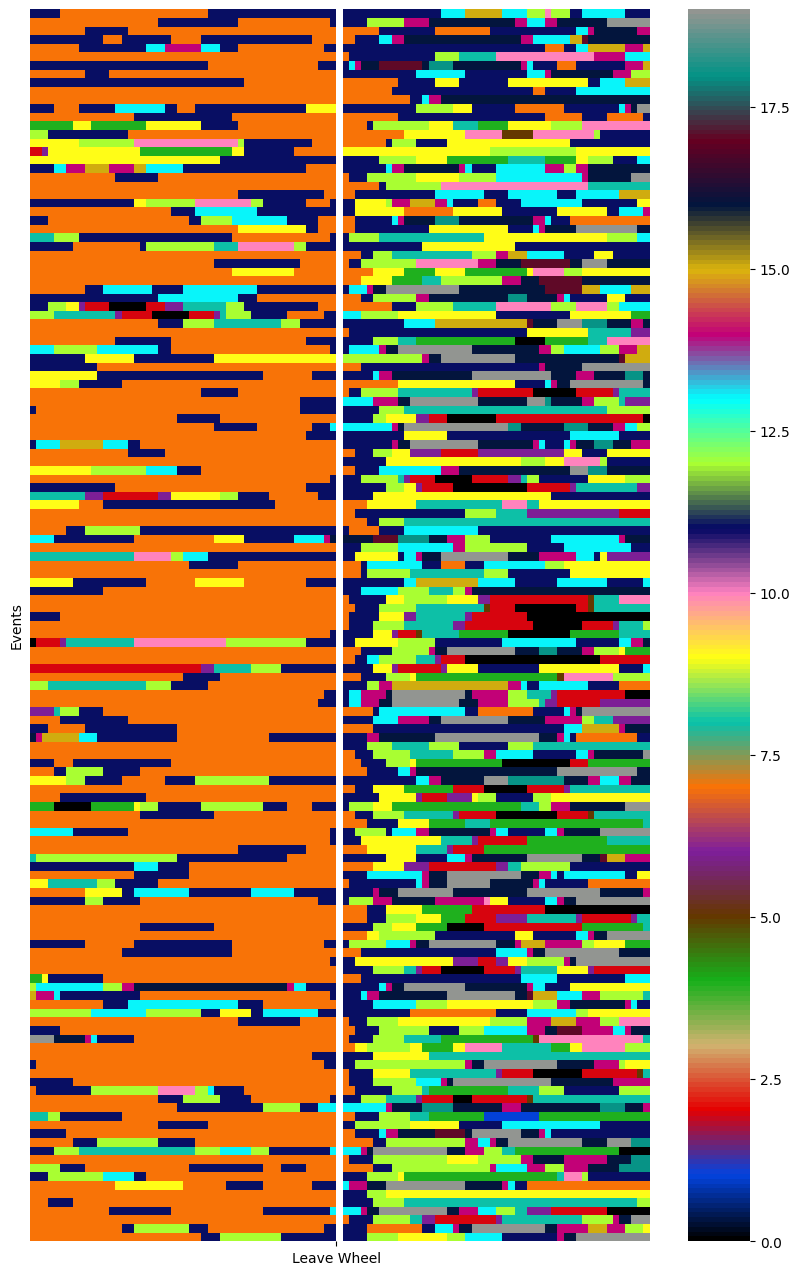

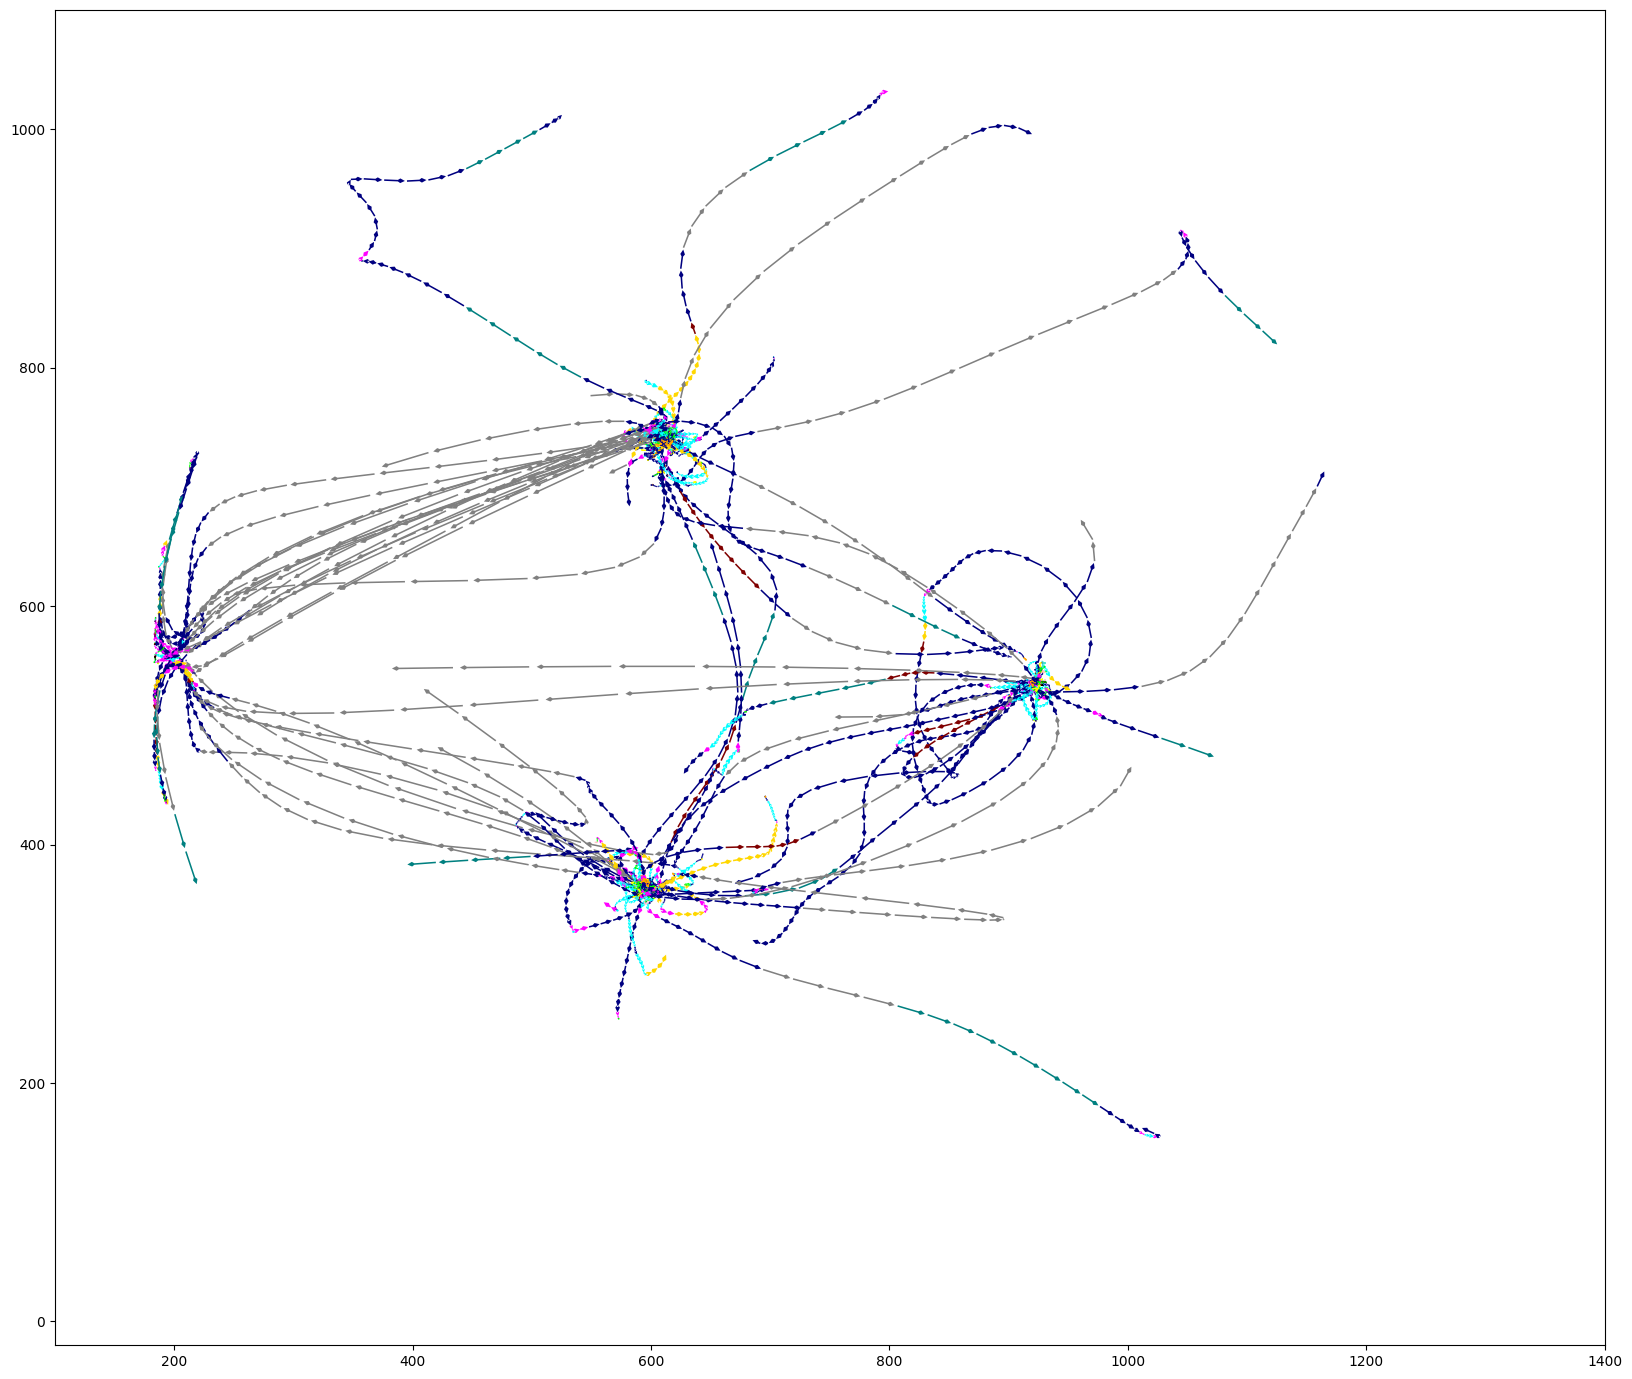

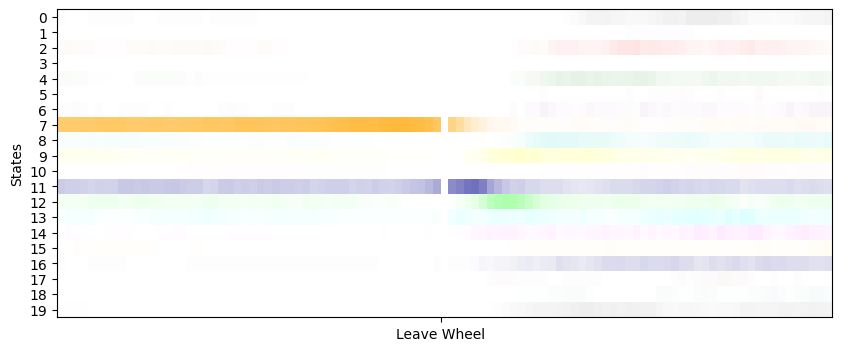

In [54]:
Characterize_Timepoints('Leave Wheel', Ends, left_seconds = 5, right_seconds = 5, file_name = 'EndVisit')

### ***iv. Pellet Deliveries***

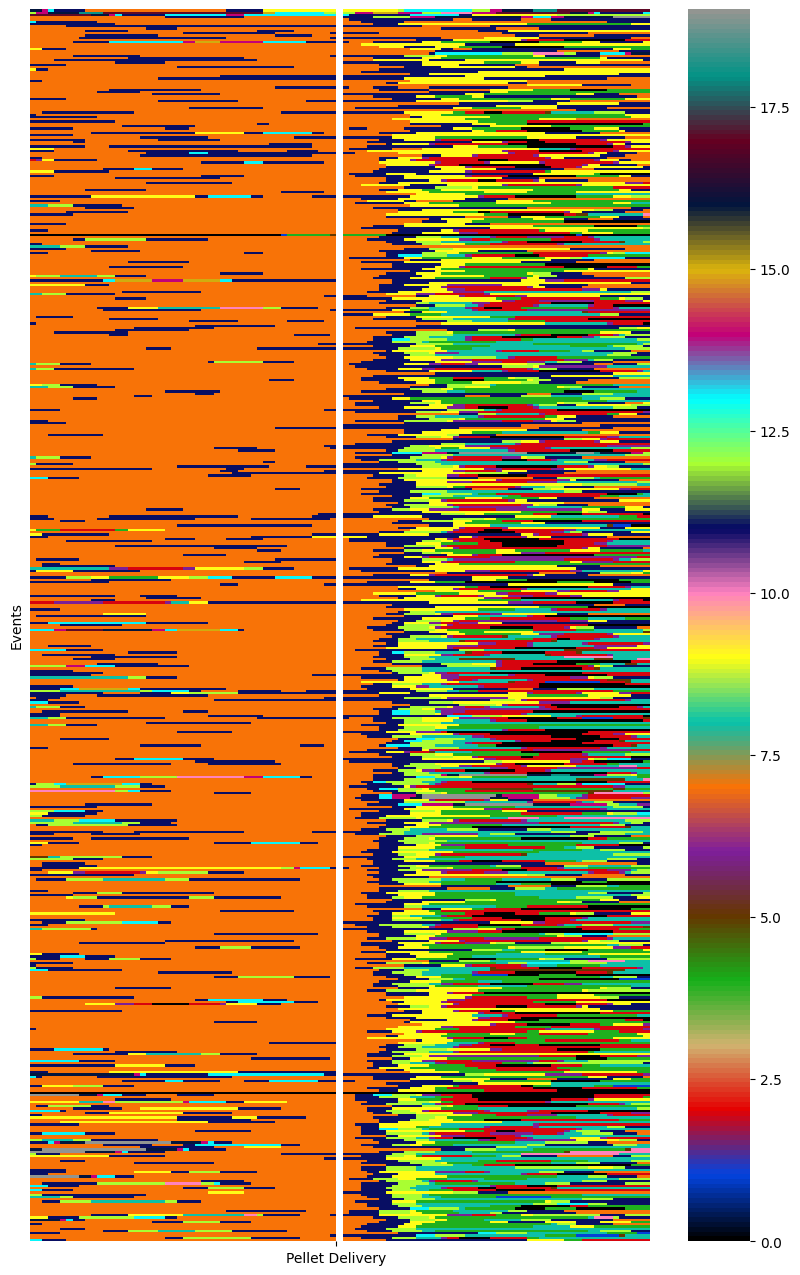

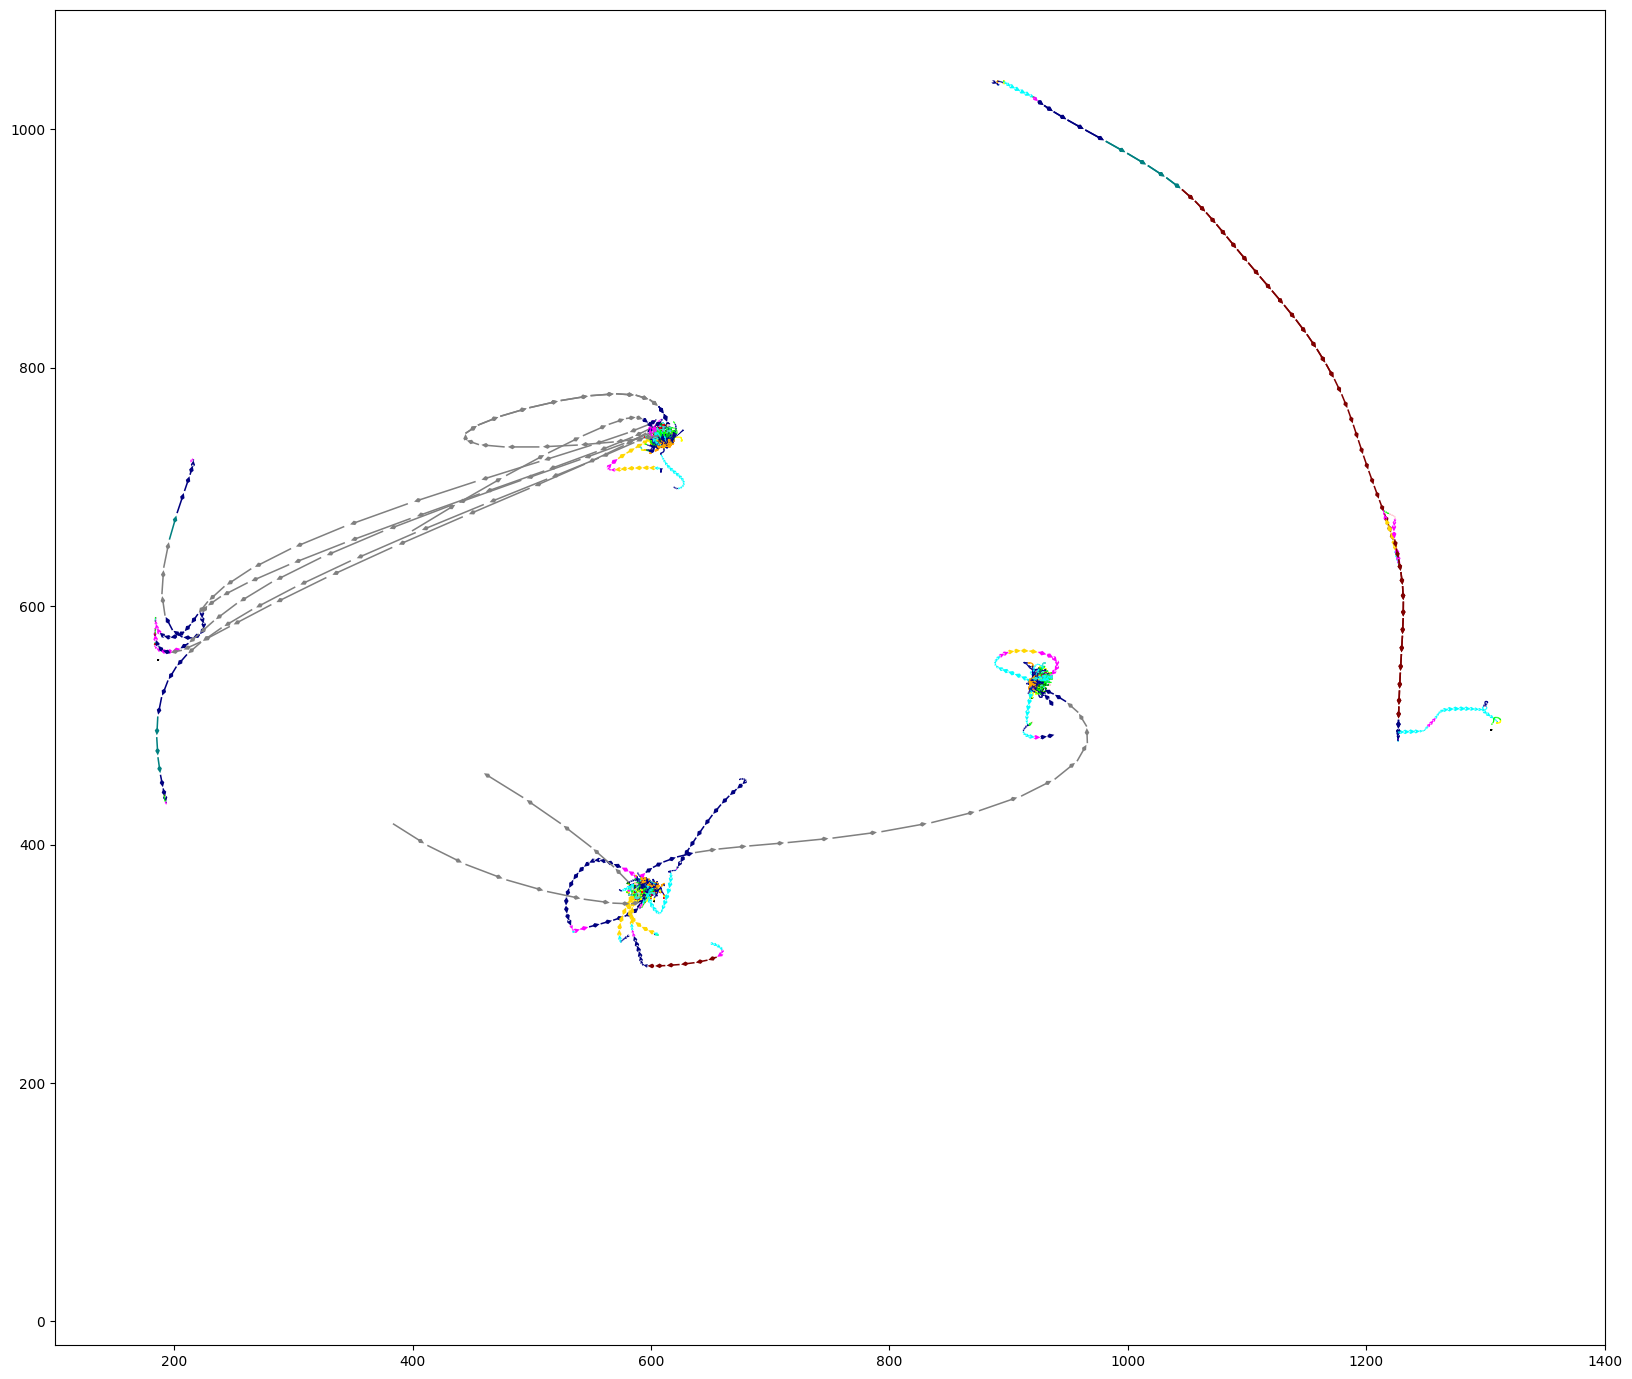

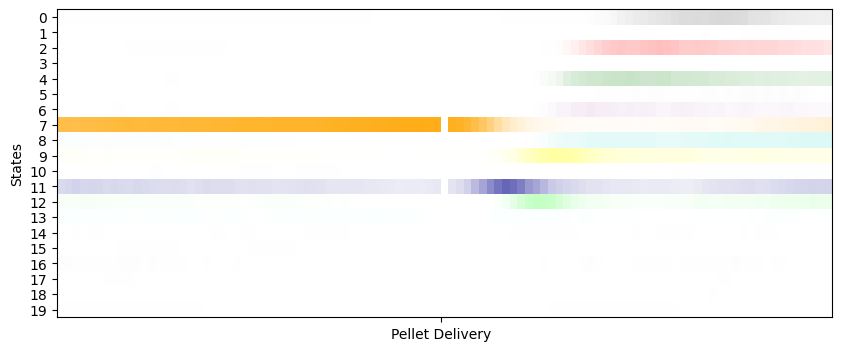

In [55]:
Characterize_Timepoints('Pellet Delivery', Pellets, left_seconds = 5, right_seconds = 5, file_name = 'PelletDelivery')

## ***IV. Prediction of Events***

In [9]:
def Calculate_Probability_Curve(characterized_states_curve = [], time_shifts = [], means = [], variances = []):
    T = len(characterized_states_curve[0])
    P = np.ones(T)
    p_ = []
    
    for i in range(len(characterized_states_curve)):
        p = np.zeros(T)
        characterized_state, time_shift, mean, variance = characterized_states_curve[i], time_shifts[i], means[i], variances[i]
        if time_shift < 0:
            p[-time_shift:] = np.exp(-((characterized_state[:time_shift] - mean) ** 2) / (2 * variance ** 2))
        else:
            p[:-time_shift] = np.exp(-((characterized_state[time_shift:] - mean) ** 2) / (2 * variance ** 2))
        p_.append(p)

    for p in p_: P *= p
    return P

def Summarize(event_name, Events):
    mouse_pos_ = mouse_pos.copy()[Active_Chunk[0]:Active_Chunk[1]]
    Events = Events[Events > Active_Chunk[0]]
    Events = Events[Events < Active_Chunk[1]]

    COUNT_CURVES = [[] for _ in range(N)]
    COUNT_CURVES_MAX = []
    for i in range(N):
        count_curves = Mouse.hmm.process_states.Event_Triggering(mouse_pos_, Events, left_seconds = 5, right_seconds = 5, variable = 'State' + str(i), insert_nan = 0)
        COUNT_CURVES[i] = np.mean(np.array(count_curves), axis = 0)
        COUNT_CURVES_MAX.append(np.max(COUNT_CURVES[i]))

    Peaks_index = np.argsort(COUNT_CURVES_MAX)
    if COUNT_CURVES_MAX[Peaks_index[-4]] > 0.4: threshold = COUNT_CURVES_MAX[Peaks_index[-4]]
    elif COUNT_CURVES_MAX[Peaks_index[-3]] < 0.4: threshold = COUNT_CURVES_MAX[Peaks_index[-3]]
    else: threshold = 0.4
    
    characterized_states, characterized_states_peak, characterized_states_names, time_shifts = [], [], [], []
    for i in range(N):
        if np.max(COUNT_CURVES[i]) > threshold:
            characterized_states.append(i)
            characterized_states_peak.append(np.max(COUNT_CURVES[i]))
            characterized_states_names.append('State'+str(i))
            max_index = np.argsort(COUNT_CURVES[i], -1)[-1]
            time_shifts.append(max_index - 50 + 3)
    return characterized_states, characterized_states_peak, characterized_states_names, time_shifts
    
def Predict(event_name, Events, file_name):
    characterized_states, characterized_states_peak, characterized_states_names, time_shifts = Summarize(event_name, Events)
    means = [1, 1,1,1,1,1, 1, 1,1,1,1,1]
    variances = [0.1, 0.1, 0.1,0.1,0.1, 0.1, 0.1, 0.1, 0.1,0.1,0.1, 0.1]
    
    if len(characterized_states) == 0:
        return 'No states characterized'

    characterized_states_curve = []
    for i in range(len(characterized_states)):
        characterized_states_curve.append(mouse_pos.loc[mouse_pos.index, characterized_states_names[i]].to_numpy())
    probability_curve = Calculate_Probability_Curve(characterized_states_curve, time_shifts = time_shifts, means = characterized_states_peak, variances = variances)
    mouse_pos.loc[mouse_pos.index, 'prob'] = probability_curve

    COUNT_CURVES = [[] for _ in range(len(characterized_states_curve))]
    Events = Events[Events > Predicting_Chunk_start]
    PROB = Mouse.hmm.process_states.Event_Triggering(mouse_pos, Events, left_seconds = 5, right_seconds = 5, variable = 'prob', insert_nan = 0)
    for i in range(len(characterized_states_curve)):
        COUNT_CURVES[i] = Mouse.hmm.process_states.Event_Triggering(mouse_pos, Events, left_seconds = 5, right_seconds = 5, variable = characterized_states_names[i], insert_nan = 0)
    
    fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    T = np.arange(-50, 50, 1)
    for i in range(len(characterized_states_curve)):
        axs.plot(T, np.mean(np.array(COUNT_CURVES[i]), axis = 0), label = characterized_states_names[i], color = color_names[int(characterized_states_names[i][-1])], linestyle = '--')
    axs.axvline(x = 0, color = 'red')
    axs.legend(loc = 'upper right')
    axs_ = axs.twinx()
    axs_.plot(T, np.mean(np.array(PROB), axis = 0), color = 'black', label = 'Pred.')
    axs_.legend(loc = 'lower right')
    plt.show()
    #plt.savefig('../Images/Social_HMM/' + file_name + '/' + Mouse_title + '_Prediction.png')
    
    return 'Predicton for ' + file_name + ' Completed'
    
Mouse_title = Mouse.type + '_' + Mouse.mouse
mouse_pos = Mouse.mouse_pos
N = Mouse.hmm.n_state
states = Mouse.hmm.states
mouse_pos['state'] = pd.Series(states, index = mouse_pos.index)

Pellets = Mouse.arena.pellets.index
Visits = Mouse.arena.visits
Entry = Mouse.arena.entry 
Starts = Visits['start'].to_numpy()
Ends = Visits['end'].to_numpy()

Active_Chunk = Mouse.active_chunk
Predicting_Chunk_start = Active_Chunk[1] + pd.Timedelta('1S')

mouse_pos = Mouse.hmm.process_states.State_Timewindow(mouse_pos, timewindow = 10)

### ***i. Enter Arena***

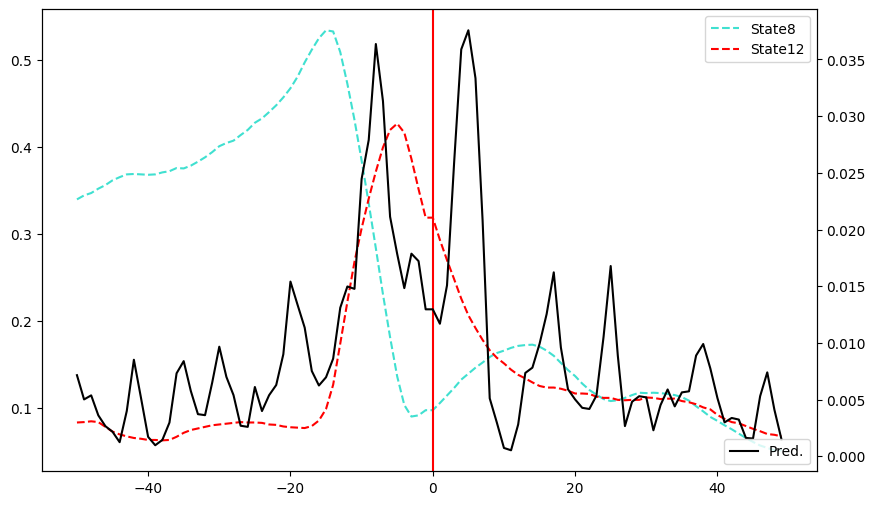

In [10]:
result = Predict(event_name = 'Enter Arena', Events = Entry, file_name = 'EnterArena')

### ***ii. Enter Patch***

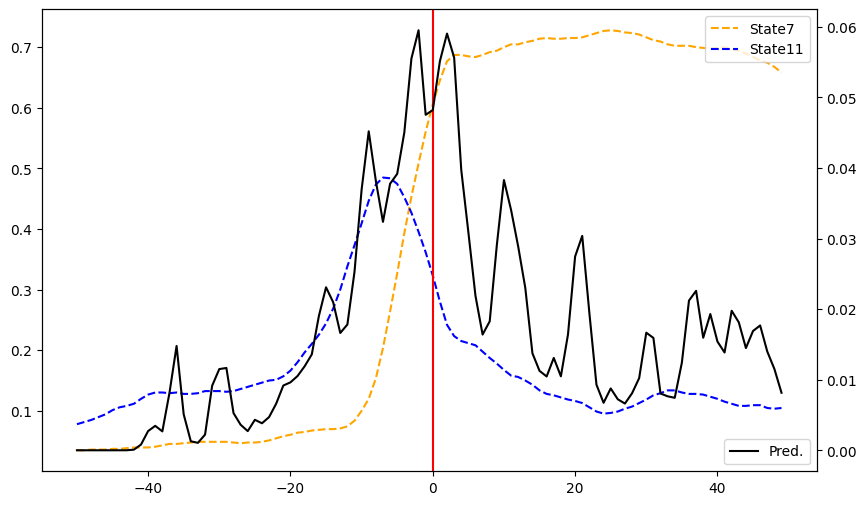

In [11]:
result = Predict(event_name = 'Move Wheel', Events = Starts, file_name = 'EnterVisit')

### ***iii. Leave Patch***

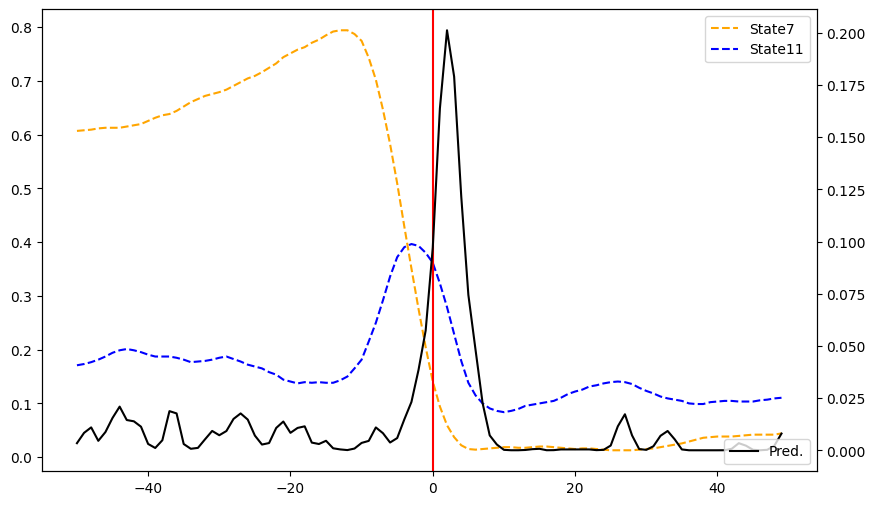

In [12]:
result = Predict(event_name = 'Leave Wheel', Events = Ends, file_name = 'EndVisit')

### ***iv. Pellet Delivery***

In [15]:
df = (Pellets[1:] - Pellets[:-1]).total_seconds()
df

Index([   7.239999771,    7.728000164, 7371.038015842,  513.737984181,
        838.807007789, 2348.581984043,   37.685023785,   45.446976185,
         17.497024059,   30.184991837,
       ...
          175.6089921,    11.14601612,   18.825984002,   27.034015655,
        375.493984223,  138.184000015,  218.268000125,    1.015007973,
        1436.85798359,  168.350016117],
      dtype='float64', name='time', length=542)

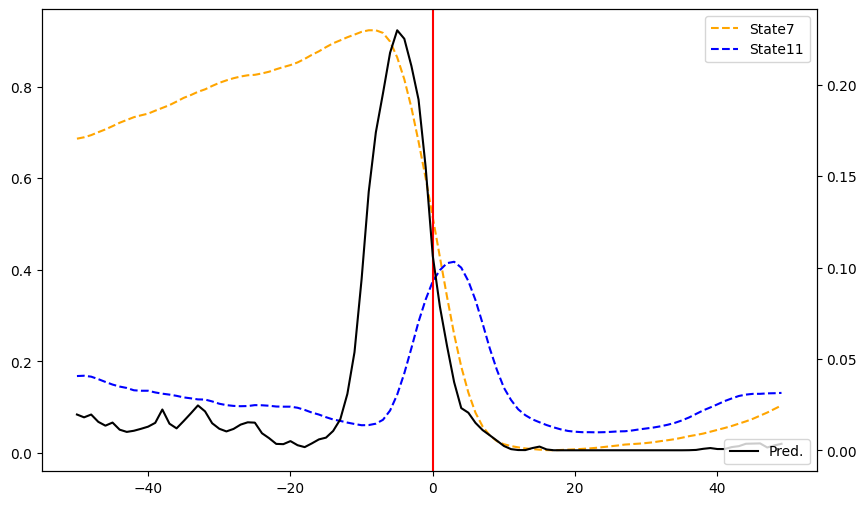

In [13]:
result = Predict(event_name = 'Pellet Delivery', Events = Pellets, file_name = 'PelletDelivery')

# **4. Display Regression Results of visit Duration**

In [23]:
def Display_Visit_Prediction(VISITS, model, file_path, title):
    regression = mouse.Regression(VISITS)
    regression.regressor = ['speed', 'acceleration', 'last_pellets_self', 'last_pellets_other','last_duration', 'last_interval','last_pellets_interval', 'entry']
    
    if model == 'linear': 
        obs, pred = regression.Linear_Regression()
    if model == 'MLP': 
        obs, pred = regression.Multilayer_Perceptron()
    
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    axs.scatter(obs, pred, s = 10)    
    axs.set_xlabel('Observation', fontsize = 24)
    axs.set_ylabel('Prediction', fontsize = 24)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    #axs.legend(fontsize = 20)
    #axs.set_ylim((-max(obs)-1, max(obs)+1))
    plt.tight_layout()
    #plt.savefig(file_path + title)
    plt.show()

## ***I. Linear Regression***

/nfs/nhome/live/zimol/ProjectAeon/SURF/Functions/mouse.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.X['interc'] = 1


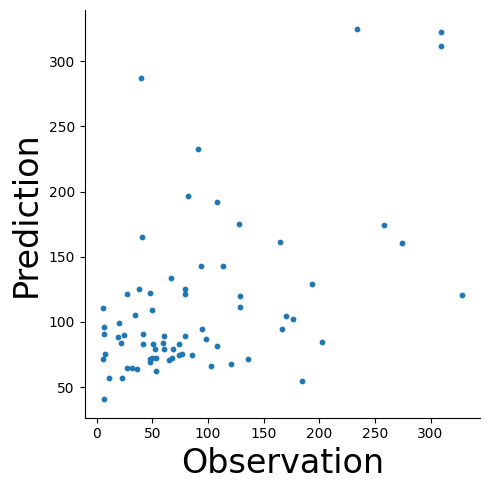

In [24]:
Display_Visit_Prediction(Mouse.arena.visits, model = 'linear', file_path = '../Images/Social_Regression/'+Mouse.type+'-'+Mouse.mouse+'/', title = 'Linear_Regression.png')                                            

## ***II. Multi-Layer Perceptron***

Epoch 1/100


/nfs/nhome/live/zimol/ProjectAeon/SURF/Functions/mouse.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.X['interc'] = 1


3/3 [==============================] - 0s 3ms/step - loss: 21663.5117 - mae: 111.2069
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 22735.2773 - mae: 111.0310
Epoch 3/100
3/3 [==============================] - 0s 2ms/step - loss: 18963.7773 - mae: 105.9367
Epoch 4/100
3/3 [==============================] - 0s 2ms/step - loss: 19208.7012 - mae: 106.2207
Epoch 5/100
3/3 [==============================] - 0s 2ms/step - loss: 19128.8789 - mae: 106.0895
Epoch 6/100
3/3 [==============================] - 0s 2ms/step - loss: 19837.8594 - mae: 106.3881
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 18715.6504 - mae: 104.3830
Epoch 8/100
3/3 [==============================] - 0s 2ms/step - loss: 18681.9180 - mae: 104.3320
Epoch 9/100
3/3 [==============================] - 0s 2ms/step - loss: 18330.4668 - mae: 103.1946
Epoch 10/100
3/3 [==============================] - 0s 2ms/step - loss: 18144.6348 - mae: 102.0181
Epoch 11/100
3/3 [=============

3/3 [==============================] - 0s 3ms/step - loss: 16047.7109 - mae: 93.6260
Epoch 23/100
3/3 [==============================] - 0s 3ms/step - loss: 16162.4863 - mae: 94.6563
Epoch 24/100
3/3 [==============================] - 0s 2ms/step - loss: 16314.1602 - mae: 94.8413
Epoch 25/100
3/3 [==============================] - 0s 2ms/step - loss: 16085.0742 - mae: 94.0275
Epoch 26/100
3/3 [==============================] - 0s 2ms/step - loss: 15410.0352 - mae: 90.9379
Epoch 27/100
3/3 [==============================] - 0s 2ms/step - loss: 15526.9238 - mae: 88.9703
Epoch 28/100
3/3 [==============================] - 0s 3ms/step - loss: 15792.6670 - mae: 92.7809
Epoch 29/100
3/3 [==============================] - 0s 2ms/step - loss: 14887.1709 - mae: 89.9833
Epoch 30/100
3/3 [==============================] - 0s 2ms/step - loss: 15083.2217 - mae: 90.8498
Epoch 31/100
3/3 [==============================] - 0s 2ms/step - loss: 280525.2812 - mae: 147.8210
Epoch 32/100
3/3 [=============

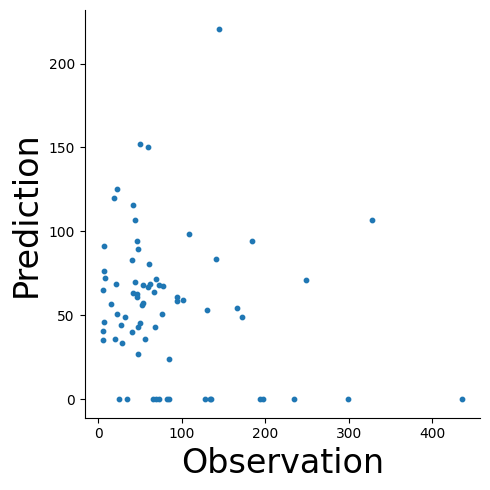

In [25]:
Display_Visit_Prediction(Mouse.arena.visits, model = 'MLP', file_path = '../Images/Social_Regression/'+Mouse.type+'-'+Mouse.mouse+'/', title = 'MLP.png')